## **University College Dublin**
## **Data Analytics (COMP47350)**
## **Student: Andressa Fontana Pires (23221657)**

## **Data Investigation: Predicting COVID-19 Mortality Risk** 

### **Introduction**

This investigation aims to build and evaluate machine learning models that can predict the risk of death associated with COVID-19. We will use a dataset sourced from the Centers for Disease Control and Prevention (CDC) that tracks COVID-19 cases and trends across the United States (https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf). The primary goal is to determine the likelihood of mortality in individuals diagnosed with the virus.

**Building on Existing Work**

We will utilise the cleaned dataset prepared during phase one of this project. To enhance the predictive power of our models, we will incorporate a new features from external sources:

- Population by State: Data was be obtained from the U.S. Census Bureau (https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html). This feature will provide context about population density, potentially influencing transmission and healthcare resource availability.
  
By incorporating this additional features, we aim to create more comprehensive models that can better capture the complex relationship between various factors and the risk of death from COVID-19.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

- Reading the our dataset:

In [11]:
original_df = pd.read_csv('covid_database_cleaned.csv')

original_df.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,current_status,symptom_status,hosp_yn,death_yn,age_group_numeric,death_yn_numeric,case_positive_specimen_interval_days,missing_case_onset_interval
0,2020-07,FL,12,MIAMI-DADE,12086,65+ years,Female,White,Hispanic/Latino,Laboratory-confirmed case,Unknown,Unknown,Yes,4,1,0.0,1
1,2021-01,FL,12,SEMINOLE,12117,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Unknown,No,Yes,4,1,0.0,1
2,2020-12,AZ,4,PIMA,4019,65+ years,Female,White,Non-Hispanic/Latino,Probable Case,Unknown,Unknown,Yes,4,1,0.0,1
3,2020-06,CA,6,FRESNO,6019,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,No,Yes,4,1,0.0,0
4,2021-09,WA,53,PIERCE,53053,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,No,Yes,4,1,0.0,0


In [12]:
num_rows = original_df.shape[0]

print("Number of rows in the dataset:", num_rows)


Number of rows in the dataset: 46051


- To account for potential variations in COVID-19 case rates across different regions, we will enrich the original dataset with a 'population' feature (based on the USA Census of 2023). This will allow us to calculate population-adjusted case rates, providing a more accurate comparison of the disease burden between areas with differing population sizes:

In [13]:
population_data = {
    'AL': 5108468,
    'AK': 733406,
    'AZ': 7431344,
    'AR': 3037732,
    'CA': 38965193,
    'CO': 5877610,
    'CT': 3617176,
    'DE': 1031890,
    'FL': 22610726,
    'GA': 11029227,
    'HI': 1435138,
    'ID': 1964726,
    'IL': 12549689,
    'IN': 6862199,
    'IA': 3207004,
    'KS': 2940546,
    'KY': 4526154,
    'LA': 4573749,
    'ME': 1395722,
    'MD': 6180253,
    'MA': 7001399,
    'MI': 10037261,
    'MN': 5737915,
    'MS': 2939690,
    'MO': 6196156,
    'MT': 1132812,
    'NE': 1978379,
    'NV': 3194176,
    'NH': 1402054,
    'NJ': 9290841,
    'NM': 2114371,
    'NY': 19571216,
    'NC': 10835491,
    'ND': 783926,
    'OH': 11785935,
    'OK': 4053824,
    'OR': 4233358,
    'PA': 12961683,
    'RI': 1095962,
    'SC': 5373555,
    'SD': 919318,
    'TN': 7126489,
    'TX': 30503301,
    'UT': 3417734,
    'VT': 647464,
    'VA': 8715698,
    'WA': 7812880,
    'WV': 1770071,
    'WI': 5910955,
    'WY': 584057,
    'DC': 671803
}

original_df['population'] = original_df['res_state'].map(population_data)

In [14]:
original_df.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,current_status,symptom_status,hosp_yn,death_yn,age_group_numeric,death_yn_numeric,case_positive_specimen_interval_days,missing_case_onset_interval,population
0,2020-07,FL,12,MIAMI-DADE,12086,65+ years,Female,White,Hispanic/Latino,Laboratory-confirmed case,Unknown,Unknown,Yes,4,1,0.0,1,22610726
1,2021-01,FL,12,SEMINOLE,12117,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Unknown,No,Yes,4,1,0.0,1,22610726
2,2020-12,AZ,4,PIMA,4019,65+ years,Female,White,Non-Hispanic/Latino,Probable Case,Unknown,Unknown,Yes,4,1,0.0,1,7431344
3,2020-06,CA,6,FRESNO,6019,65+ years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,No,Yes,4,1,0.0,0,38965193
4,2021-09,WA,53,PIERCE,53053,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case,Symptomatic,No,Yes,4,1,0.0,0,7812880


- Saving the merged and cleaned dataset to a new csv file:

In [15]:
original_df.to_csv('new_dataset.csv', index=False)
complete_df = original_df.copy() 

- Setting the features types:

In [16]:
column_types = {
    # Categorical Variables
    "case_month": "category",
    "res_state": "category",
    "state_fips_code": "category",
    "res_county": "category",
    "county_fips_code": "category",
    "age_group": "category",
    "sex": "category",
    "race": "category",
    "ethnicity": "category",
    "current_status": "category",
    "symptom_status": "category",
    "hosp_yn": "category",
    "death_yn": "category",
    "age_group_numeric": "category",
    "death_yn_numeric": "category",
    "missing_case_onset_interval": "category",
    
    # Continuous Variables
    "case_positive_specimen_interval_days": "float64",
    "population": "float64",  
  
}


complete_df = complete_df.astype(column_types)

complete_df.dtypes

case_month                              category
res_state                               category
state_fips_code                         category
res_county                              category
county_fips_code                        category
age_group                               category
sex                                     category
race                                    category
ethnicity                               category
current_status                          category
symptom_status                          category
hosp_yn                                 category
death_yn                                category
age_group_numeric                       category
death_yn_numeric                        category
case_positive_specimen_interval_days     float64
missing_case_onset_interval             category
population                               float64
dtype: object

### **Data Understanding and Preparation:**

- Splitting the dataset into trainning and testing samples:

In [17]:
X = complete_df.drop(columns=['death_yn'])
y = complete_df['death_yn_numeric'] #mapping = {'Yes': 1, 'No': 0}

# Splitting the dataset into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
print("Training set size (X_train):", X_train.shape)
print("Test set size (X_test):", X_test.shape)
print("Training set size (y_train):", y_train.shape)
print("Test set size (y_test):", y_test.shape)

# Checking for overlap between training and test sets
intersection = set(X_train.index) & set(X_test.index)
if len(intersection) == 0:
    print("No overlap between training and test sets.")
else:
    print("Overlap found between training and test sets.")

print("Sample indices in training set:", X_train.index[:5])
print("Sample indices in test set:", X_test.index[:5])


Training set size (X_train): (32235, 17)
Test set size (X_test): (13816, 17)
Training set size (y_train): (32235,)
Test set size (y_test): (13816,)
No overlap between training and test sets.
Sample indices in training set: Index([43570, 194, 26037, 34821, 33503], dtype='int64')
Sample indices in test set: Index([7397, 681, 36278, 31591, 42593], dtype='int64')


- Stats of the continuous features (now with the new feature 'population'):

In [19]:
continuous_features_full_dataset = ['case_positive_specimen_interval_days', 'population']
df_filtered = original_df[continuous_features_full_dataset ]

In [20]:
summary_stats = complete_df[continuous_features_full_dataset ].describe().T

# Calculating missing value percentages
missing_percentage_filtered = (1 - complete_df[continuous_features_full_dataset ].count() / len(df_filtered)) * 100

# Calculating cardinality (number of unique values)
cardinality_filtered = complete_df[continuous_features_full_dataset ].nunique()

# Combining all statistics
summary_stats_with_missing_card_filtered = summary_stats.assign(
    percent_missing = missing_percentage_filtered,
    cardinality = cardinality_filtered
)

summary_stats_with_missing_card_filtered

,count,mean,std,min,25%,50%,75%,max,percent_missing,cardinality
case_positive_specimen_interval_days,46051.0,7.702113e-01,9.769522e+00,0.0,0.0,0.0,0.0,651.0,0.0,42
population,46051.0,1.237598e+07,8.809497e+06,584057.0,6180253.0,9290841.0,19571216.0,38965193.0,0.0,48


### Plotting the correlations between all the continuous features:

- Correlation matrix of the continuous features:

In [21]:
continuous_features_full_dataset = ['case_positive_specimen_interval_days', 'population']
df_filtered = original_df[continuous_features_full_dataset ]

correlation_matrix = df_filtered.corr()

correlation_matrix

,case_positive_specimen_interval_days,population
case_positive_specimen_interval_days,1.000000,-0.001284
population,-0.001284,1.000000


-  Heatmap visualization of the correlation matrix above:

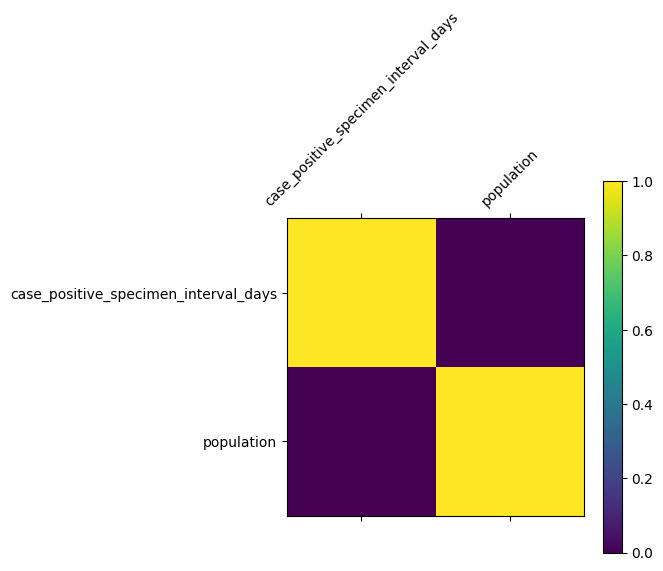

In [22]:
plt.matshow(correlation_matrix)
plt.xticks(range(len(continuous_features_full_dataset)), continuous_features_full_dataset, rotation=45)
plt.yticks(range(len(continuous_features_full_dataset)), continuous_features_full_dataset)
plt.colorbar()
plt.show()


- Interpretation: The correlation coefficient between 'case_positive_specimen_interval_days' and itself is 1, which is expected because it represents the correlation of a variable with itself (perfect correlation). The correlation coefficient between 'case_positive_specimen_interval_days' and 'population' is approximately -0.0013. This indicates a very weak negative correlation between these two variables. In practical terms, there's almost no linear relationship between the number of days between specimen collection and population size. Overall, based on the correlation coefficients, there doesn't appear to be a significant linear relationship between these two variables in your dataset.

- Scatter plots of the correlation of the continuous features:

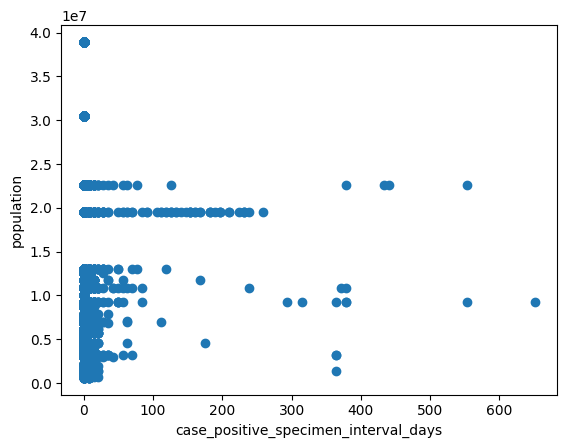

In [23]:
continuous_features_full_dataset = ['case_positive_specimen_interval_days', 'population']
df_filtered = original_df[continuous_features_full_dataset ]

for i in range(len(continuous_features_full_dataset)):
    for j in range(i + 1, len(continuous_features_full_dataset)):
        plt.scatter(df_filtered.iloc[:, i], df_filtered.iloc[:, j])
        plt.xlabel(continuous_features_full_dataset[i])
        plt.ylabel(continuous_features_full_dataset[j])
        plt.show()


Interpretation: The scatter plot shows visualy the relationship between the timing of positive case reports and population size. Most cases are reported shortly after specimen collection, regardless of population size. This reinforces that the timing of positive case reports is not strongly influenced by population size.

### Plotting the correlations between the continuous features with the target feature:

- Plotting the pairwise interaction of 'case_positive_specimen_interval_days' with the target feature:

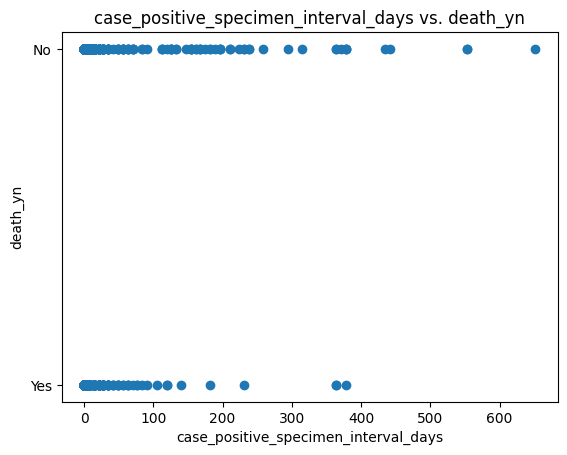

In [24]:
target_variable = 'death_yn'
plt.scatter(original_df['case_positive_specimen_interval_days'], original_df[target_variable])
plt.xlabel('case_positive_specimen_interval_days')
plt.ylabel(target_variable)
plt.title("case_positive_specimen_interval_days vs. " + target_variable)
plt.show()


/var/folders/6j/tmdg_xx172xb1xtgxd35y2400000gn/T/ipykernel_9512/1283018970.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='death_yn_numeric', y='case_positive_specimen_interval_days', data=avg_interval_by_death, palette='muted')


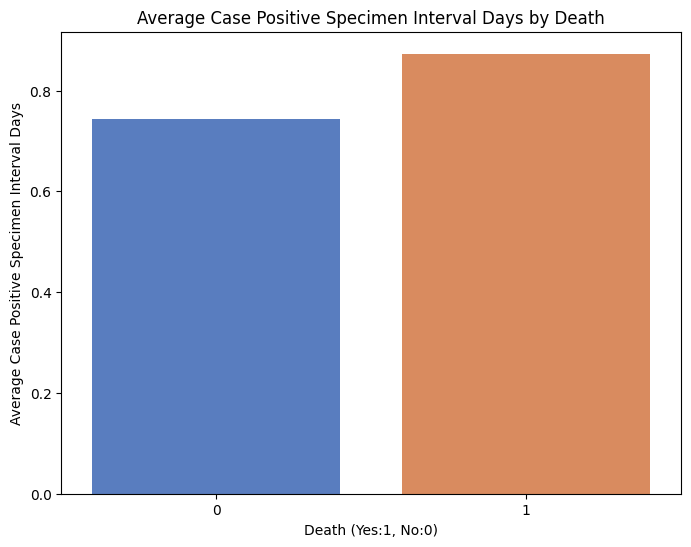

In [25]:
avg_interval_by_death = original_df.groupby('death_yn_numeric')['case_positive_specimen_interval_days'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='death_yn_numeric', y='case_positive_specimen_interval_days', data=avg_interval_by_death, palette='muted')
plt.xlabel('Death (Yes:1, No:0)')
plt.ylabel('Average Case Positive Specimen Interval Days')
plt.title('Average Case Positive Specimen Interval Days by Death')
plt.show()

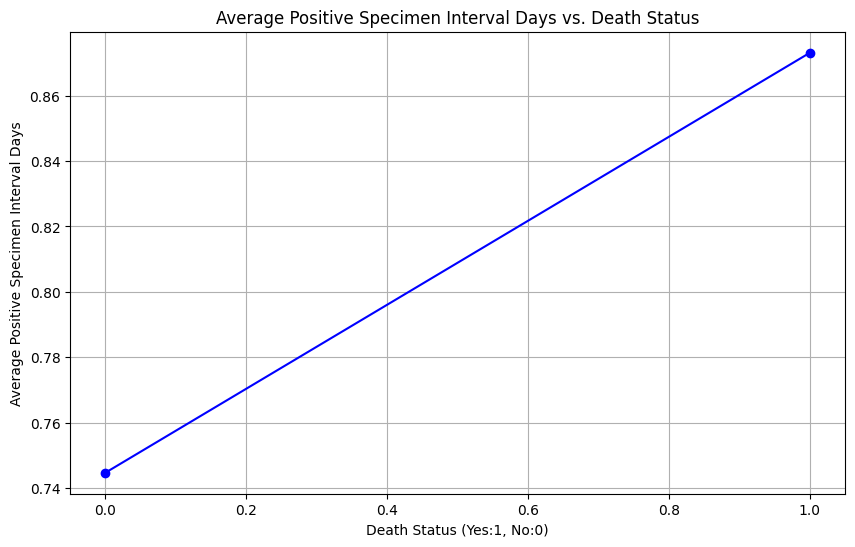

In [26]:
# Calculate the mean positive specimen interval days by death status
avg_interval_by_death = original_df.groupby('death_yn_numeric')['case_positive_specimen_interval_days'].mean().reset_index()

# Plotting the line plot
plt.figure(figsize=(10, 6))
plt.plot(avg_interval_by_death.index, avg_interval_by_death['case_positive_specimen_interval_days'], marker='o', color='blue')
plt.title('Average Positive Specimen Interval Days vs. Death Status')
plt.xlabel('Death Status (Yes:1, No:0)')
plt.ylabel('Average Positive Specimen Interval Days')
plt.grid(True)
plt.show()


- Interpretation: A longer interval of infection confirmation appears to be associated with a slightly higher tendency of death, as seen on the graphs above. This indicates that delays in confirming cases may indeed contribute, albeit minimally, to an increased risk of mortality

- Plotting the pairwise interaction of 'population' with the target feature:

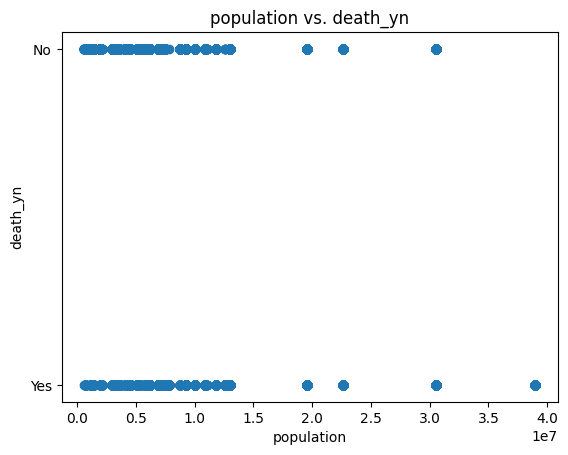

In [27]:
target_variable = 'death_yn'
plt.scatter(original_df['population'], original_df[target_variable])
plt.xlabel('population')
plt.ylabel(target_variable)
plt.title("population vs. " + target_variable)
plt.show()


/var/folders/6j/tmdg_xx172xb1xtgxd35y2400000gn/T/ipykernel_9512/2307113635.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='death_yn_numeric', y='population', data=avg_interval_by_death, palette='muted')


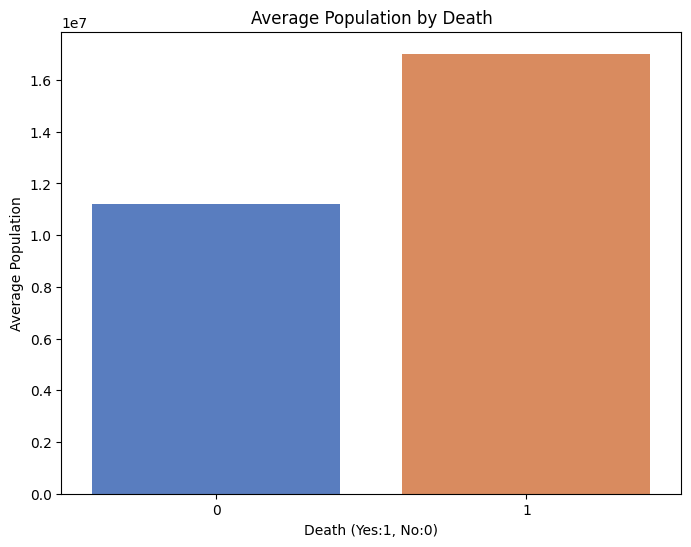

In [28]:
# Calculate the average interval by death
avg_interval_by_death = original_df.groupby('death_yn_numeric')['population'].mean().reset_index()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='death_yn_numeric', y='population', data=avg_interval_by_death, palette='muted')
plt.xlabel('Death (Yes:1, No:0)')
plt.ylabel('Average Population')
plt.title('Average Population by Death')
plt.show()


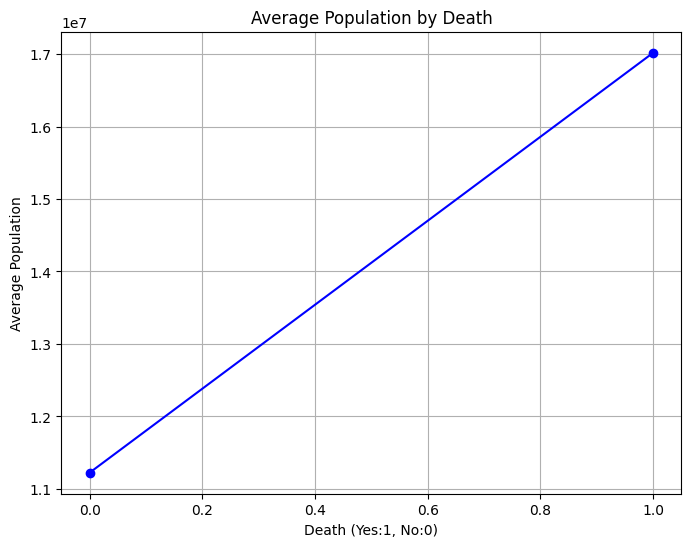

In [29]:
# Calculate the mean population by death status
avg_population_by_death = original_df.groupby('death_yn_numeric')['population'].mean().reset_index()

# Plotting the line plot
plt.figure(figsize=(8, 6))
plt.plot(avg_population_by_death['death_yn_numeric'], avg_population_by_death['population'], marker='o', color='blue', linestyle='-')
plt.xlabel('Death (Yes:1, No:0)')
plt.ylabel('Average Population')
plt.title('Average Population by Death')
plt.grid(True)
plt.show()


- Interpreation: When analysing the relationship between population size and mortality rates, larger populations tend to exhibit higher mortality rates. This observation hints at a potential correlation between population size and mortality, underscoring the likelihood that areas with larger populations face heightened challenges in managing healthcare resources. Consequently, these challenges may contribute to elevated mortality rates during health crises or disease outbreaks. It is expected that with more people comes a higher likelihood of infection, and consequently, more fatalities. Factors such as higher population density, increased disease transmission rates, and difficulties in healthcare resource allocation, alongside other socio-economic factors, may further exacerbate this correlation.

### Plotting the pairwise interaction of the categorical features with the target feature:

- 'case_month':

<Figure size 1200x800 with 0 Axes>

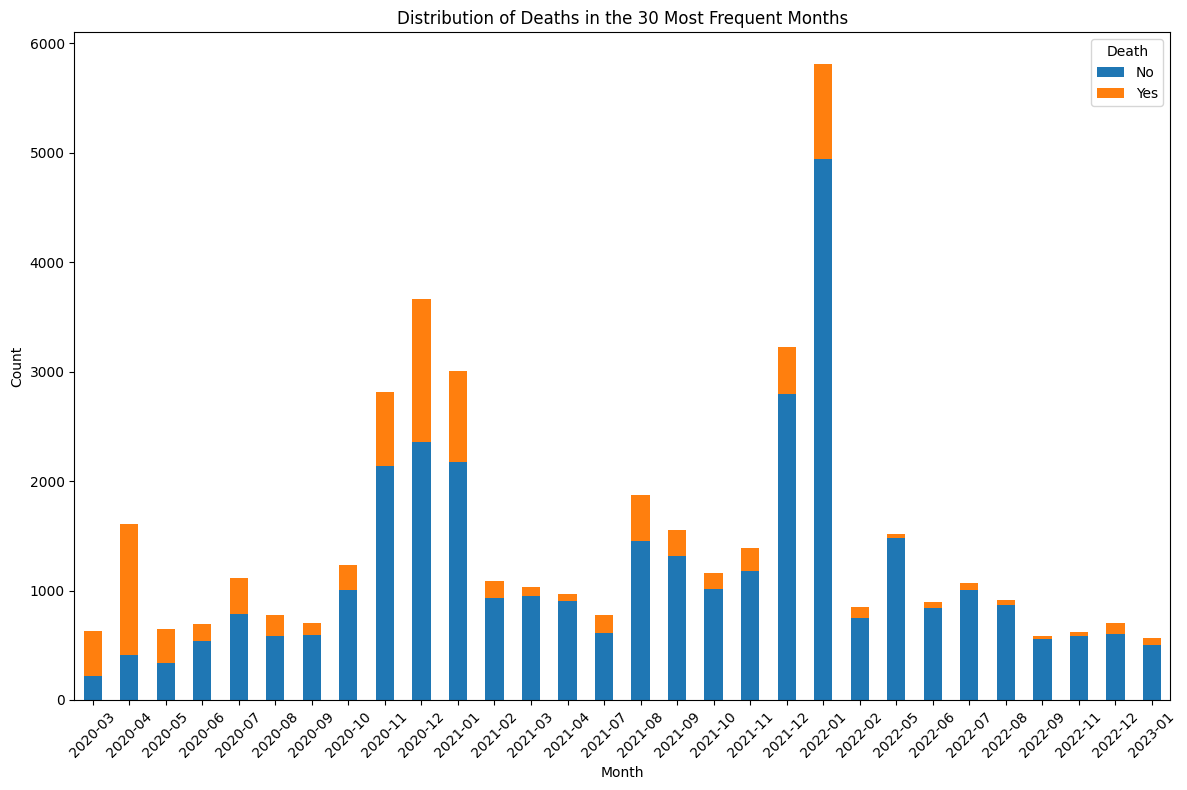

In [30]:
top_months = original_df['case_month'].value_counts().nlargest(30).index

top_months_data = complete_df[original_df['case_month'].isin(top_months)]

cross_tab_top_months = pd.crosstab(top_months_data['case_month'], top_months_data['death_yn'])

plt.figure(figsize=(12, 8))
cross_tab_top_months.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Deaths in the 30 Most Frequent Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Death')
plt.tight_layout()
plt.show()


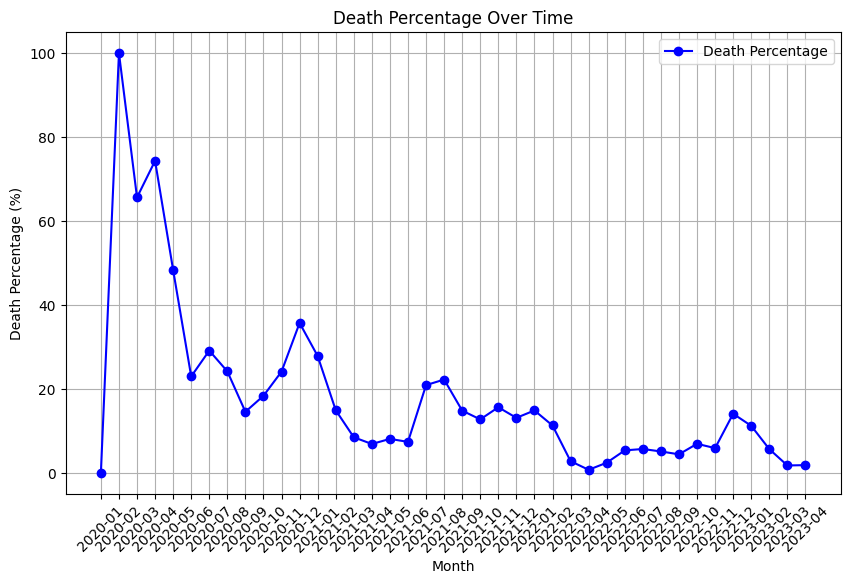

In [31]:
monthly_data = original_df.groupby(['case_month', 'death_yn']).size().unstack(fill_value=0)

monthly_data['death_percentage'] = (monthly_data['Yes'] / (monthly_data['Yes'] + monthly_data['No'])) * 100

plt.figure(figsize=(10, 6))

plt.plot(monthly_data.index, monthly_data['death_percentage'], marker='o', color='blue', label='Death Percentage')

plt.title('Death Percentage Over Time')
plt.xlabel('Month')
plt.ylabel('Death Percentage (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

In [32]:
cases_by_month = original_df.groupby('case_month').size()

month_with_most_cases = cases_by_month.idxmax()
highest_cases_count = cases_by_month.max()

print(f"The month with the highest number of cases is {month_with_most_cases} with {highest_cases_count} cases.")


The month with the highest number of cases is 2022-01 with 5810 cases.


In [33]:
deaths_df = original_df[complete_df['death_yn'] == 'Yes']

deaths_by_month = deaths_df.groupby('case_month').size()

month_with_most_deaths = deaths_by_month.idxmax()
highest_deaths_count = deaths_by_month.max()

print(f"The month with the highest number of deaths is {month_with_most_deaths} with {highest_deaths_count} deaths.")


The month with the highest number of deaths is 2020-12 with 1308 deaths.


- Interpretation: Our analysis of the plots reveals a concerning trend of higher COVID-19 cases and deaths concentrated in the early stages of the pandemic, particularly in 2020 and 2021. This pattern extends into January 2022, which saw the highest number of cases (5,810) reported. While December 2020 held the record for the most fatalities (1,308), a promising shift emerged over time. Death rates, initially exceeding 40% of all cases during the first five months, began a gradual decline. This trend of decreasing cases and deaths continued throughout the rest of 2022 and into early 2023.

- 'res_state':

<Figure size 1200x800 with 0 Axes>

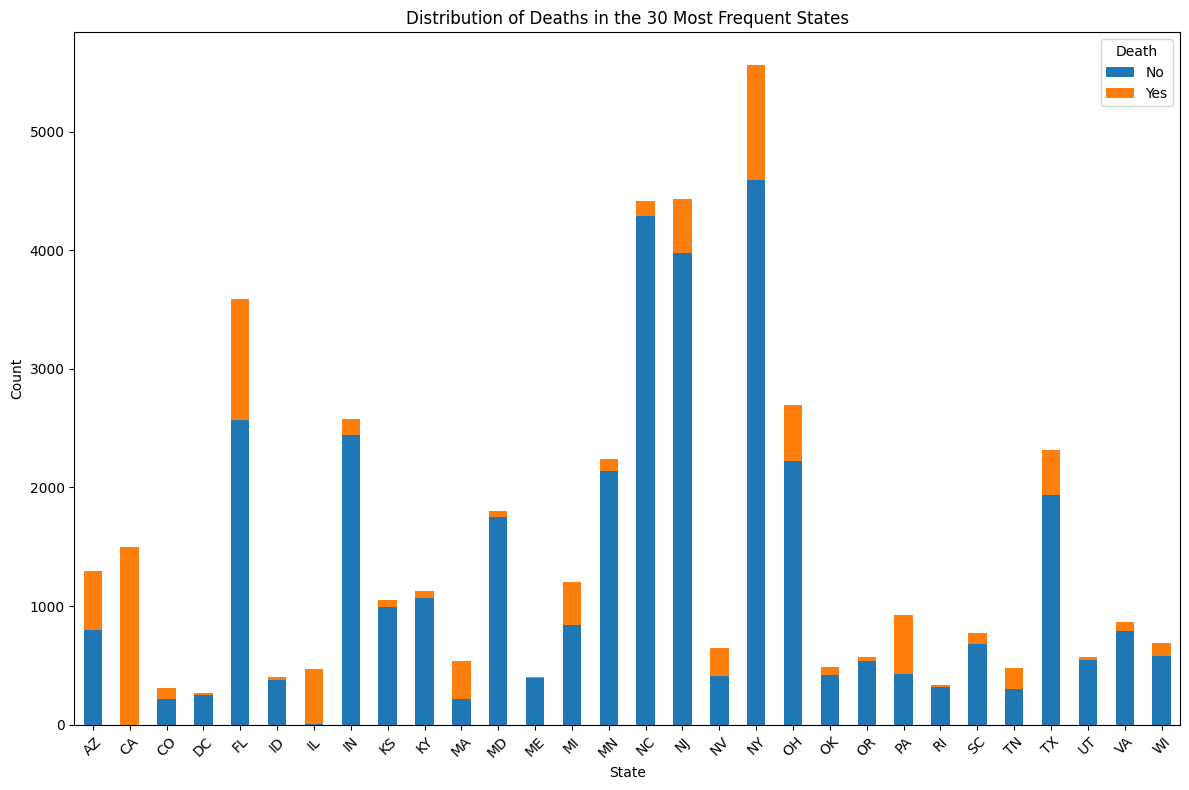

In [34]:
top_states = original_df['res_state'].value_counts().nlargest(30).index
top_states_data = complete_df[original_df['res_state'].isin(top_states)]

cross_tab_top = pd.crosstab(top_states_data['res_state'], top_states_data['death_yn'])

plt.figure(figsize=(12, 8))
cross_tab_top.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Deaths in the 30 Most Frequent States')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Death')
plt.tight_layout()
plt.show()

/var/folders/6j/tmdg_xx172xb1xtgxd35y2400000gn/T/ipykernel_9512/705807403.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  population_by_state = top_states_data.groupby('res_state')['population'].mean()


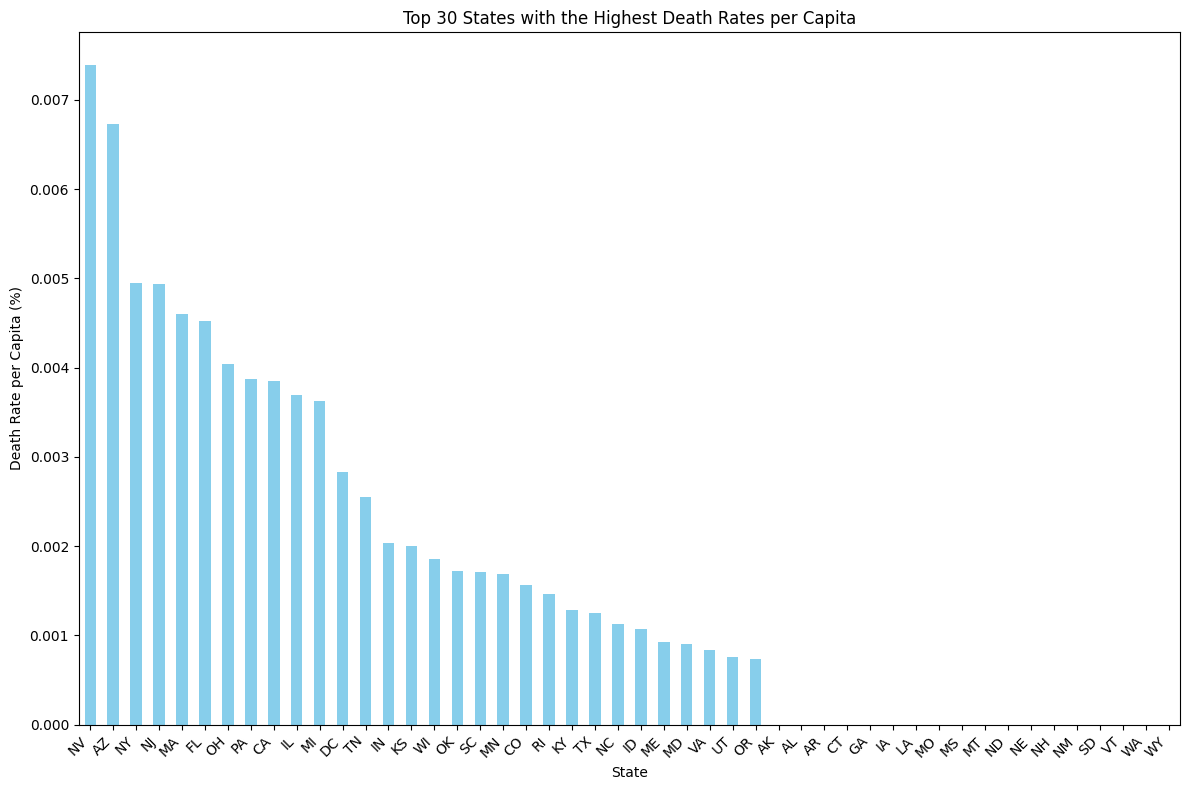

In [35]:
cross_tab_top = pd.crosstab(top_states_data['res_state'], top_states_data['death_yn'])

population_by_state = top_states_data.groupby('res_state')['population'].mean()

death_rate_per_capita = (cross_tab_top['Yes'] / population_by_state) * 100

death_rate_per_capita_sorted = death_rate_per_capita.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
death_rate_per_capita_sorted.plot(kind='bar', color='skyblue')
plt.title('Top 30 States with the Highest Death Rates per Capita')
plt.xlabel('State')
plt.ylabel('Death Rate per Capita (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Interpretation: Our examination of states with high COVID-19 caseloads (e.g., NY, NC, NJ, FL) reveals that despite significant case numbers, death rates varied considerably across these regions. This suggests that case counts alone are not a reliable predictor of fatalities. The second plot further emphasizes this point by visualizing death rates per capita relative to caseloads. The observed disparity is evident in states like NV, AZ, NY, MA, PA, IL, and MI, highlighting the influence of factors beyond infections on pandemic severity. Variations in healthcare infrastructure, population demographics, adherence to public health measures, and the presence of viral strains likely contribute to these differing mortality rates. This underscores the complex nature of the pandemic and the need for tailored strategies to mitigate its effects across diverse regions. 

- 'res_county':

<Figure size 1200x800 with 0 Axes>

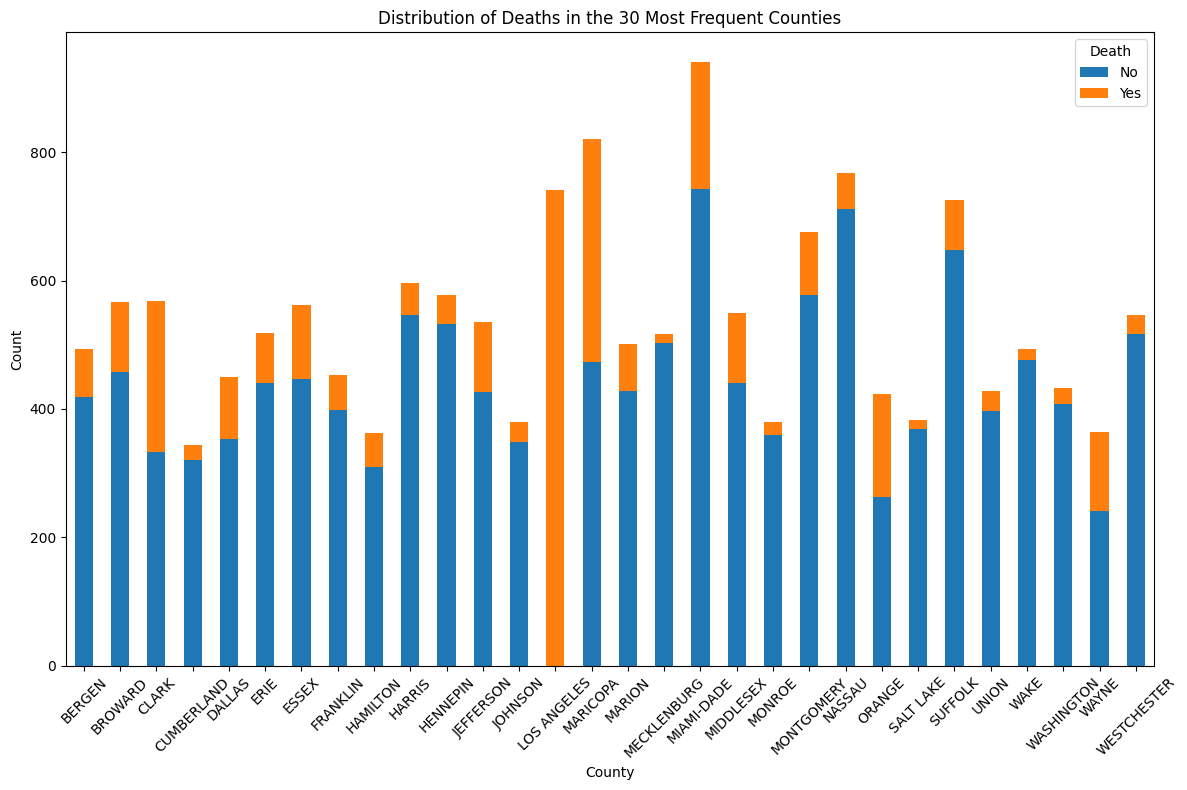

In [36]:
top_counties = original_df['res_county'].value_counts().nlargest(30).index

top_counties_data = original_df[original_df['res_county'].isin(top_counties)]

cross_tab_top = pd.crosstab(top_counties_data['res_county'], top_counties_data['death_yn'])

plt.figure(figsize=(12, 8))
cross_tab_top.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Deaths in the 30 Most Frequent Counties')
plt.xlabel('County')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Death')
plt.tight_layout()
plt.show()


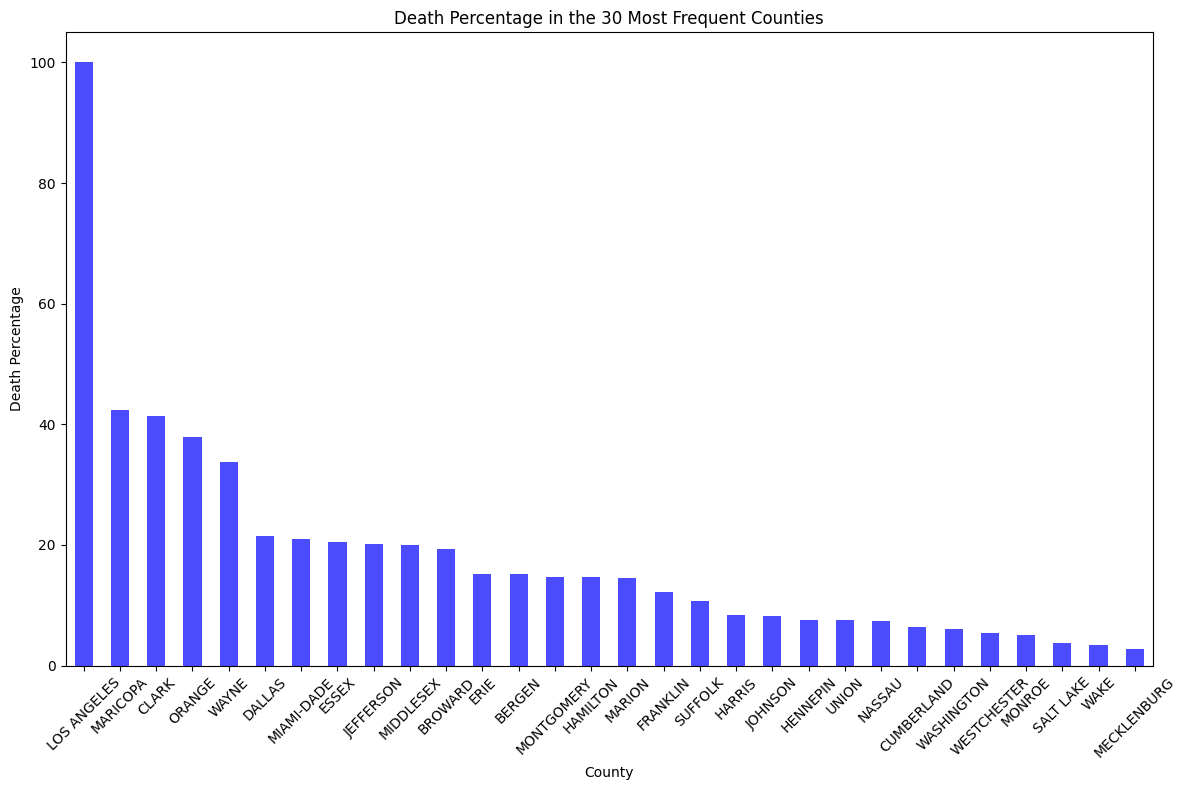

In [37]:
top_counties = original_df['res_county'].value_counts().nlargest(30).index

top_counties_data = original_df[original_df['res_county'].isin(top_counties)]

cross_tab_top = pd.crosstab(top_counties_data['res_county'], top_counties_data['death_yn'])

cross_tab_top['Death Percentage'] = cross_tab_top['Yes'] / (cross_tab_top['Yes'] + cross_tab_top['No']) * 100

cross_tab_top = cross_tab_top.sort_values(by='Death Percentage', ascending=False)

plt.figure(figsize=(12, 8))
cross_tab_top['Death Percentage'].plot(kind='bar', color='blue', alpha=0.7)
plt.title('Death Percentage in the 30 Most Frequent Counties')
plt.xlabel('County')
plt.ylabel('Death Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- Interpretation: When examining counties, it's evident that those with the highest number of cases also tended to have the highest number of deaths. Counties like Los Angeles, Maricopa, and Clark, for instance, exhibited this trend. This suggests a stronger correlation between case occurrence and death at the county level compared to the state level. 

- 'age_group': 

In [38]:
correlation = original_df['death_yn_numeric'].corr(original_df['age_group_numeric'])
print("Pearson correlation coefficient:", correlation)

Pearson correlation coefficient: 0.605227606689584


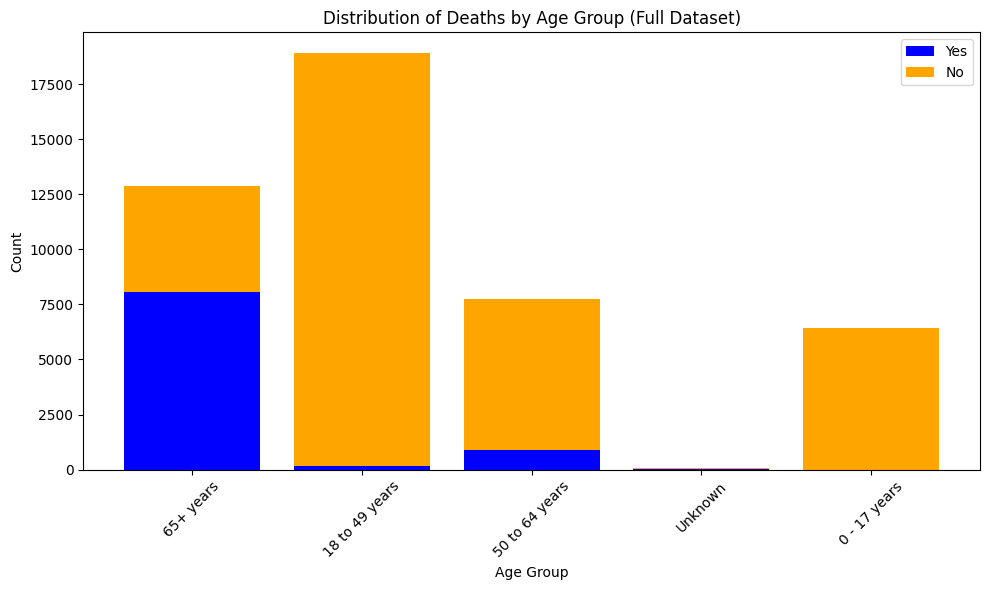

In [39]:
age_groups = original_df['age_group'].unique()
counts_yes = []
counts_no = []

for age_group in age_groups:
    counts_yes.append(complete_df[(complete_df['age_group'] == age_group) & (complete_df['death_yn_numeric'] == 1)].shape[0])
    counts_no.append(complete_df[(complete_df['age_group'] == age_group) & (complete_df['death_yn_numeric'] == 0)].shape[0])

plt.figure(figsize=(10, 6))
plt.bar(age_groups, counts_yes, label='Yes', color='blue')
plt.bar(age_groups, counts_no, bottom=counts_yes, label='No', color='orange')

plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Distribution of Deaths by Age Group (Full Dataset)')
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

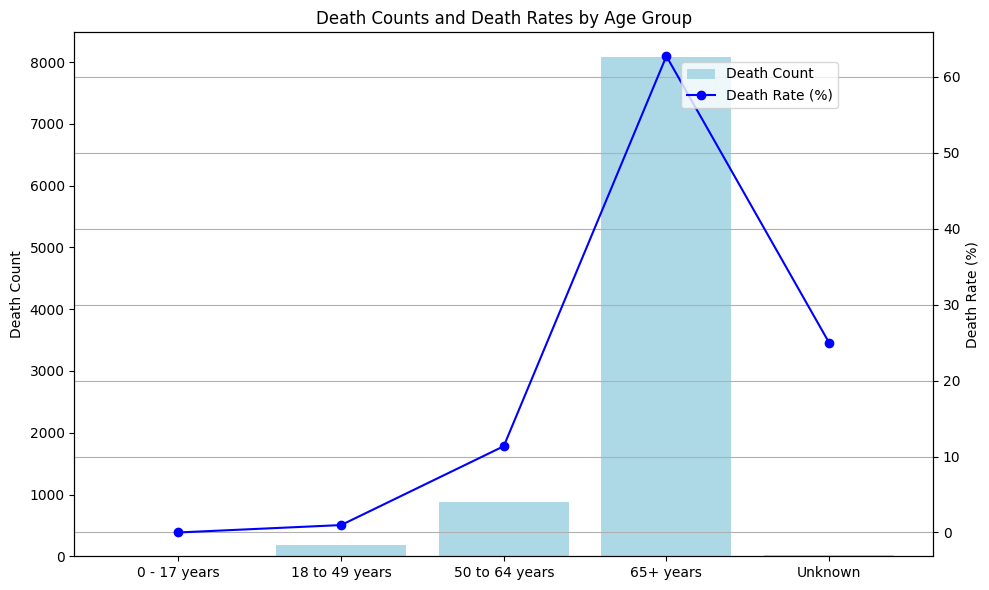

In [40]:
age_group_deaths = original_df.groupby('age_group')['death_yn'].value_counts().unstack().fillna(0)
age_group_deaths['death_rate'] = (age_group_deaths['Yes'] / age_group_deaths.sum(axis=1)) * 100

# Defining the age group bins
age_bins = ['0 - 17 years', '18 to 49 years', '50 to 64 years', '65+ years', 'Unknown']

age_group_deaths = age_group_deaths.reindex(age_bins, fill_value=0)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(age_group_deaths.index, age_group_deaths['Yes'], color='lightblue', label='Death Count')

ax2 = ax1.twinx()
ax2.plot(age_group_deaths.index, age_group_deaths['death_rate'], color='blue', marker='o', label='Death Rate (%)')

ax1.set_ylabel('Death Count')
ax2.set_ylabel('Death Rate (%)')
plt.title('Death Counts and Death Rates by Age Group')

fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.9))

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- Interpretation: The analysis reveals a clear correlation between age and COVID-19 severity. While younger adults (18 to 49 years) experience more cases, older adults (65+ years) face a much higher risk of death from the virus. The lack of data on underlying health conditions limits further insights, but available data strongly suggests older populations are more vulnerable to severe outcomes.

- 'sex':


<Figure size 1200x800 with 0 Axes>

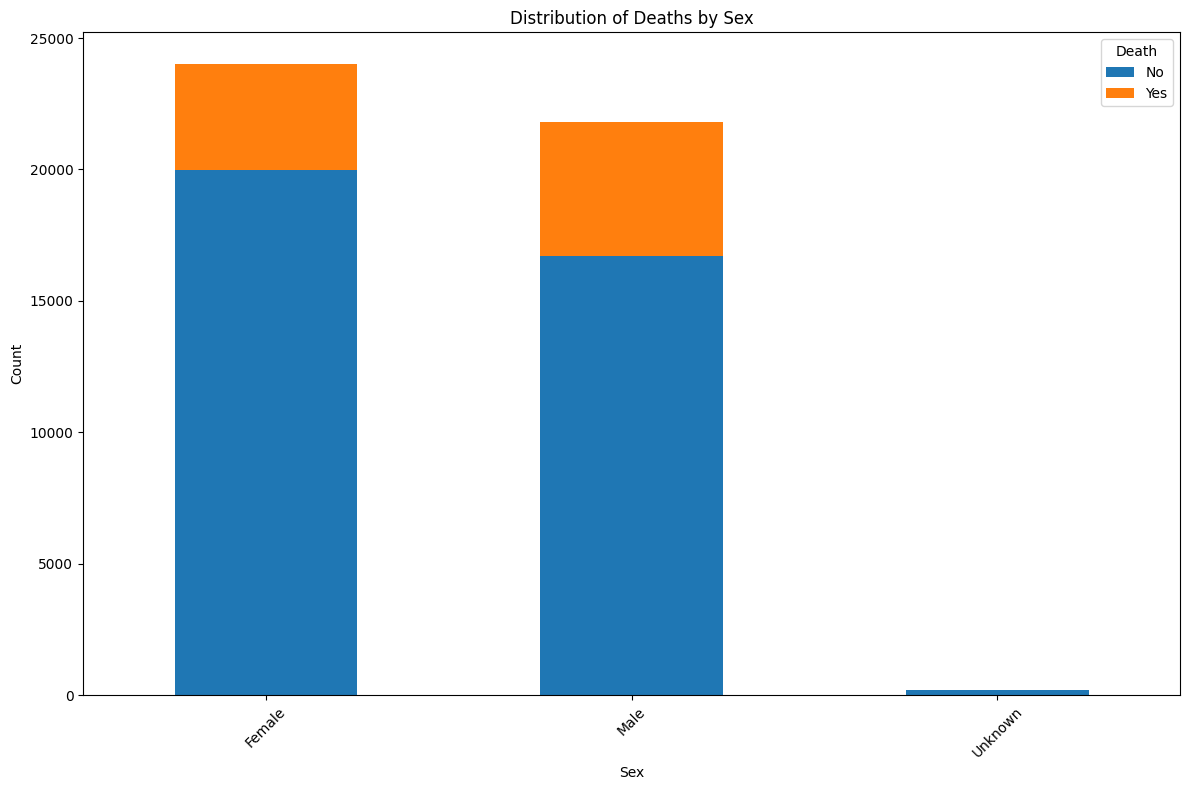

In [41]:
top_sexes = original_df['sex'].value_counts().nlargest(10).index

top_sexes_data = complete_df[original_df['sex'].isin(top_sexes)]

cross_tab_top_sex = pd.crosstab(top_sexes_data['sex'], top_sexes_data['death_yn'])

plt.figure(figsize=(12, 8))
cross_tab_top_sex.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Deaths by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Death')
plt.tight_layout()
plt.show()


Percentage of deaths by sex:


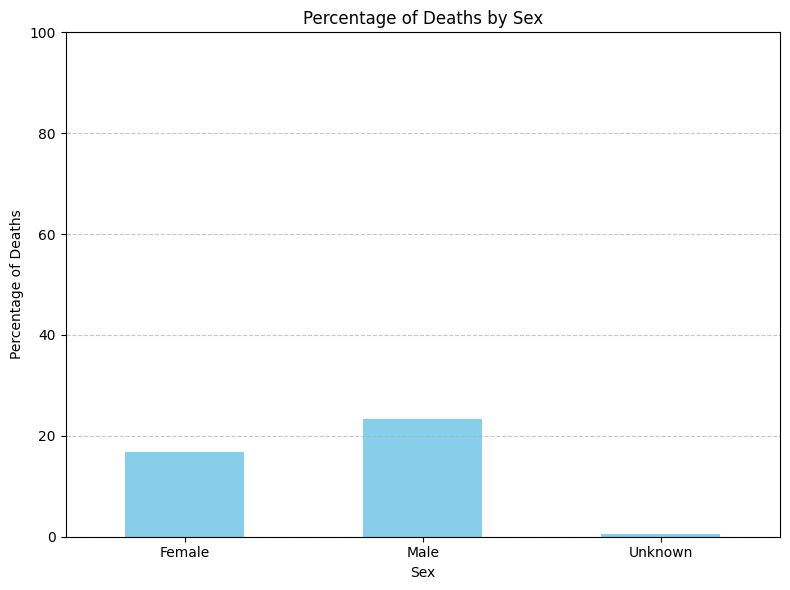

sex
Female     16.855430
Male       23.432918
Unknown     0.473934
Name: count, dtype: float64

In [42]:
total_cases_by_sex = original_df['sex'].value_counts()

total_deaths_by_sex = original_df[original_df['death_yn'] == 'Yes']['sex'].value_counts()

death_percentage_by_sex = (total_deaths_by_sex / total_cases_by_sex) * 100

print("Percentage of deaths by sex:")


plt.figure(figsize=(8, 6))
death_percentage_by_sex.plot(kind='bar', color='skyblue')
plt.title('Percentage of Deaths by Sex')
plt.xlabel('Sex')
plt.ylabel('Percentage of Deaths')
plt.xticks(rotation=0)
plt.ylim(0, 100)  # Set y-axis limit to 0-100%
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
death_percentage_by_sex

- Interpretation: Although females slightly outnumber males in reported cases, the death percentage was higher for males. Upon examination of the graphs, it was found that among infected female individuals, 16.8% died, while male individuals accounted for 23.4% of the total death cases.

- 'race':


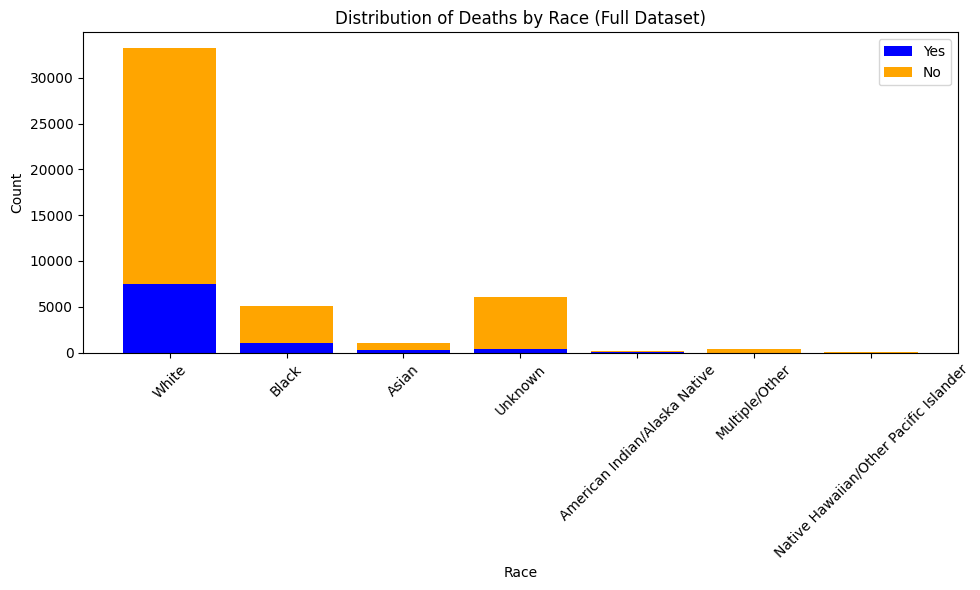

In [43]:
race_groups = original_df['race'].unique()
counts_yes = []
counts_no = []

for race_group in race_groups:
    counts_yes.append(original_df[(original_df['race'] == race_group) & (original_df['death_yn_numeric'] == 1)].shape[0])
    counts_no.append(original_df[(original_df['race'] == race_group) & (original_df['death_yn_numeric'] == 0)].shape[0])

plt.figure(figsize=(10, 6))
plt.bar(race_groups, counts_yes, label='Yes', color='blue')
plt.bar(race_groups, counts_no, bottom=counts_yes, label='No', color='orange')

plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Deaths by Race (Full Dataset)')
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


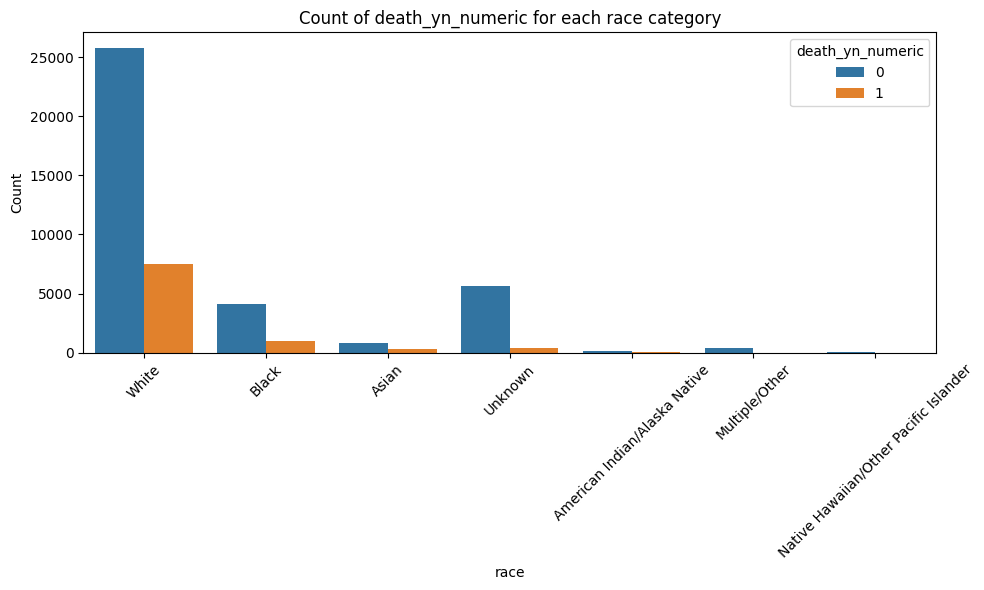

In [44]:
categorical_feature = 'race'
outcome_variable = 'death_yn_numeric' #mapping = {'Yes': 1, 'No': 0}

plt.figure(figsize=(10, 6))
sns.countplot(data=original_df, x=categorical_feature, hue=outcome_variable)
plt.title(f'Count of {outcome_variable} for each {categorical_feature} category')
plt.xlabel(categorical_feature)
plt.ylabel('Count')
plt.legend(title=outcome_variable)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

- Interpretation: White individuals constitute the largest racial group among reported cases, also accounting the highest death cases. However, it's crucial to recognize that this distribution within the dataset may not accurately reflect the true population demographics. Further analysis is imperative to evaluate the significance of this information, particularly in light of potential socio-economic factors and inequalities that may disproportionately affect access to healthcare services for Black communities in the USA.

- 'ethnicity':

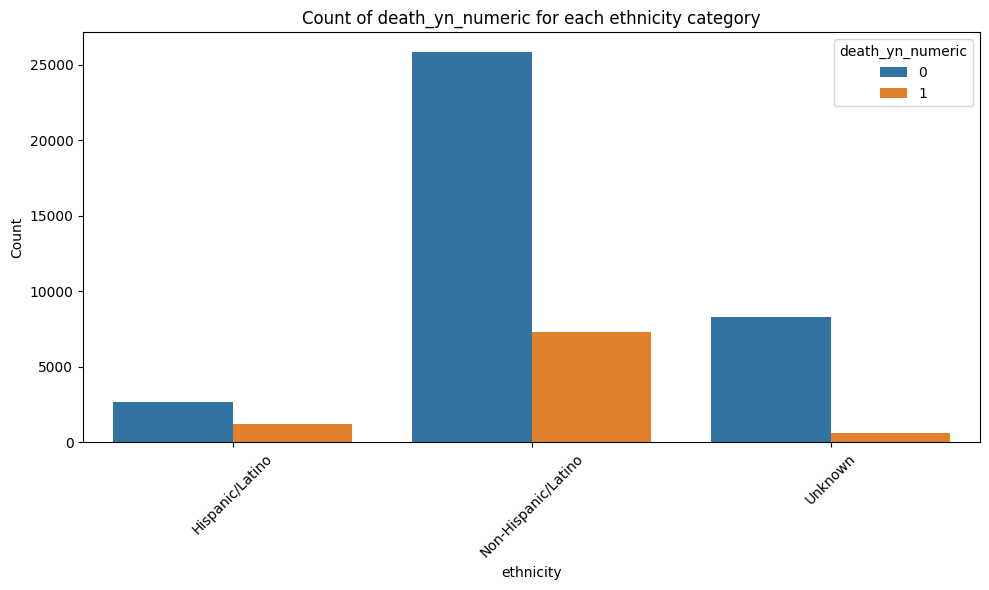

In [45]:
categorical_feature = 'ethnicity'
outcome_variable = 'death_yn_numeric'

plt.figure(figsize=(10, 6))
sns.countplot(data=original_df, x=categorical_feature, hue=outcome_variable)
plt.title(f'Count of {outcome_variable} for each {categorical_feature} category')
plt.xlabel(categorical_feature)
plt.ylabel('Count')
plt.legend(title=outcome_variable)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

Interpretation: Non- Hispanic/Latino constitute the largest racial group among reported cases, also accounting the highest death cases. However, it's crucial to recognize that this distribution within the dataset may not accurately reflect the true population demographics. Just like the previous racial feature, ethnicity  also requires further analysis to evaluate the significance of this information, particularly in light of potential socio-economic factors and inequalities that may disproportionately affect access to healthcare services for Hispanic/Latino and many others communities in the USA.

- 'current_status':

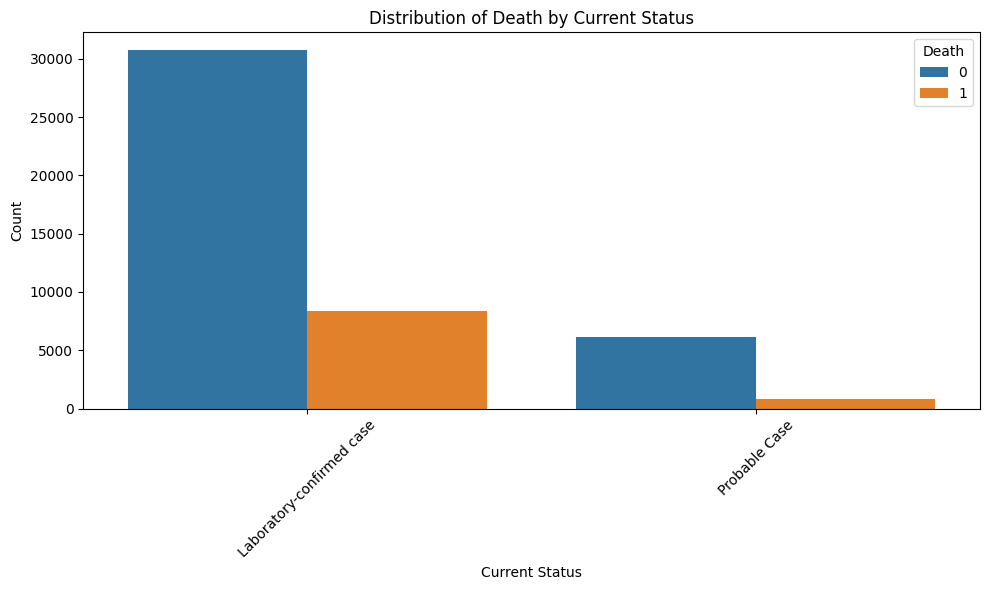

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(data=original_df, x='current_status', hue='death_yn_numeric')
plt.title('Distribution of Death by Current Status')
plt.xlabel('Current Status')
plt.ylabel('Count')
plt.legend(title='Death')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Interpretation: Laboratory-confirmed cases show a higher frequency of death registrations, indicating a logical association between confirmed infection and mortality. However, on its own, this feature may not be decisive in predicting mortality outcomes considering it clear impact on death or not. Combining this information with other variables, such as treatment data, could provide more valuable insights. Unfortunately, the dataset lacks such detailed information, limiting our ability to gain a comprehensive understanding of mortality determinants.

- 'symptom_status':

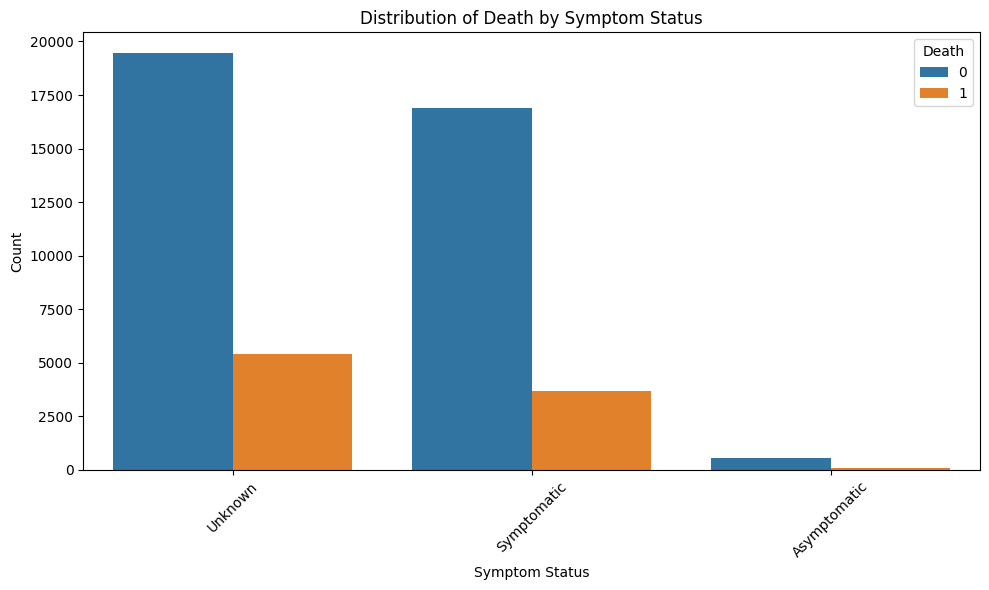

In [47]:
plt.figure(figsize=(10, 6))
sns.countplot(data=original_df, x='symptom_status', hue='death_yn_numeric')
plt.title('Distribution of Death by Symptom Status')
plt.xlabel('Symptom Status')
plt.ylabel('Count')
plt.legend(title='Death')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Interpretation: The symptomatic status feature may not be highly relevant for predicting death due to its high number of missing values. However, it's notable that symptomatic individuals have a higher likelihood of death compared to registered asymptomatic cases. Further analysis is needed to confirm this trend, although, it's important to acknowledge that confirmation is challenging with the current feature due to its possible nature - Missing at Random (MAR). In MAR, missing data can be related to observed variables but not to the missing data itself. Imputation methods may introduce bias, especially since most reported cases are from young people who didn't experience mortality. Moreover, young people, who tend to have fewer symptoms, may not accurately inform missing data regarding symptomatic status and its correlation with mortality. Therefore, caution is needed when drawing conclusions from this data.

- 'hosp_yn':

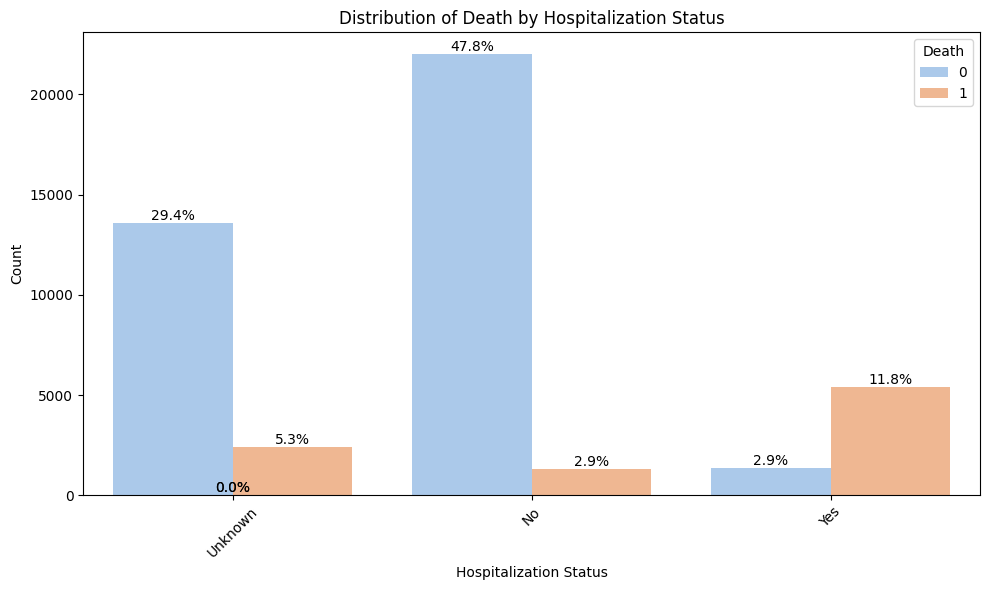

In [48]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=original_df, x='hosp_yn', hue='death_yn_numeric', palette='pastel')

plt.title('Distribution of Death by Hospitalization Status')
plt.xlabel('Hospitalization Status')
plt.ylabel('Count')
plt.legend(title='Death')

# Calculating percentage of death for each category
total = len(complete_df)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.1%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Interpretation: A notable discrepancy exists in the frequency of death between individuals not hospitalized and those with negative or missing hospitalization status. This observation suggests that hospitalization status may indeed play a crucial role in determining mortality outcomes. Out of all death cases related to hospitalization status, the most frequent ones (11.8%) were connected to individuals who were hospitalized. Further investigation into the factors influencing hospitalization decisions, such as underlying conditions and symptom status, would be beneficial. However, it's crucial to note that the dataset lacks reliable values related to these elements, limiting the depth of analysis in this regard.

- 'missing_case_onset_interval':

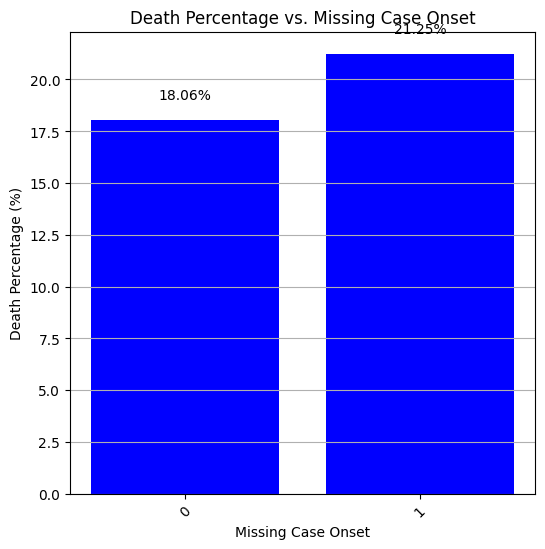

In [49]:
missing_onset_data = original_df.groupby('missing_case_onset_interval')['death_yn'].value_counts(normalize=True).unstack().fillna(0)

missing_onset_data = missing_onset_data.reindex(columns=['Yes', 'No'], fill_value=0)

missing_onset_data['death_percentage'] = missing_onset_data['Yes'] * 100

plt.figure(figsize=(6, 6))
plt.bar(missing_onset_data.index.astype(str), missing_onset_data['death_percentage'], color='blue')
plt.title('Death Percentage vs. Missing Case Onset')
plt.xlabel('Missing Case Onset')
plt.ylabel('Death Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')

for i, percentage in enumerate(missing_onset_data['death_percentage']):
    plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center')

plt.show()

- Interpretation: Analysis of the case onset interval data suggests it may not be a strong predictor of COVID-19 mortality. This is because the presence or absence of this information does not significantly impact the death rate. While the death rate for cases with a missing onset interval is 18%, it's only slightly higher, 21.2%, for cases with a known onset interval


### **Which continuous features seem to be better at predicting the target feature?**

  - 'case_positive_specimen_interval_days': This feature represents the number of days between when a COVID-19 case is confirmed positive and when the specimen was collected. And seen previously, delays in confirming cases may indeed contribute, albeit minimally, to an increased risk of mortality.

  - 'population': As seen previously, higher population density can increase the risk of virus transmission, leading to higher case counts and potentially higher mortality rates.

 
### **Which categorical features seem to be better at predicting the target feature?**
  
  - 'case_month': The timing of COVID-19 cases can provide insights into trends and patterns over time, which may influence mortality rates due to factors such as seasonality, changes in healthcare capacity, and the effectiveness of public health measures.
    
  - 'res_state': State-level data can help identify regional variations in COVID-19 mortality rates, which may be influenced by factors such as population density, healthcare infrastructure, public health policies, and demographic characteristics. ADD WHY THIS AND NOT COUNTY....
    
  - 'age_group': Age is a significant risk factor for COVID-19 mortality, with older individuals generally facing higher mortality rates.
    
  - 'sex': Sex differences in COVID-19 mortality have been observed, with males often experiencing higher mortality rates compared to females. 
    
  - 'hosp_yn': Hospitalization status, as seen above, is a strong predictor of COVID-19 mortality. Severe cases requiring hospitalization are more likely to result in adverse outcomes. 
    
  - 'current_status': indicates that the COVID-19 case has been confirmed through laboratory testing. As seen previously, "Laboratory-confirmed" cases show a higher frequency of death registrations, indicating a logical association between confirmed infection and mortality. 


### **Training a Linear Regression model to predict the target feature (on the training set using the descriptive features previously selected)**

In [50]:
# Selected descriptive features
selected_features = ['case_positive_specimen_interval_days', 'population', 
                     'case_month', 'res_state', 'age_group', 
                     'sex', 'current_status', 'hosp_yn']


X = complete_df[selected_features]
y = complete_df['death_yn_numeric'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Defining the columns to be one-hot encoded
categorical_cols = ['case_month', 'res_state', 'age_group', 'sex', 'current_status', 'hosp_yn']

# Creating a preprocessor that will one-hot encode the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Keeping non-categorical columns unchanged
)

# Creating a pipeline with preprocessing and linear regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Training the model on the training set
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['case_month', 'res_state',
                                                   'age_group', 'sex',
                                                   'current_status',
                                                   'hosp_yn'])])),
                ('regressor', LinearRegression())])

### **Printing the coefficients learned by the model**

In [51]:
# Accessing the LinearRegression model from the pipeline
linear_regressor = model.named_steps['regressor']

# Getting feature names after one-hot encoding
one_hot_encoder = model.named_steps['preprocessor'].named_transformers_['cat']
one_hot_encoded_feature_names = one_hot_encoder.get_feature_names_out(input_features=categorical_cols)

# Combining feature names after one-hot encoding and their coefficients into a dataframe
all_feature_names = list(one_hot_encoded_feature_names) + list(X.columns[len(categorical_cols):])
coefficients_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': linear_regressor.coef_})

pd.set_option('display.max_rows', None)

print("Coefficients:")
print(coefficients_df)


Coefficients:
                                      Feature   Coefficient
0                          case_month_2020-01 -7.904846e-20
1                          case_month_2020-02  6.484001e-19
2                          case_month_2020-03  8.038965e-17
3                          case_month_2020-04  2.413230e-16
4                          case_month_2020-05  5.373623e-17
5                          case_month_2020-06  3.915532e-18
6                          case_month_2020-07  2.940430e-17
7                          case_month_2020-08  8.542401e-18
8                          case_month_2020-09 -1.170809e-17
9                          case_month_2020-10 -4.102314e-18
10                         case_month_2020-11  3.645897e-17
11                         case_month_2020-12  1.658408e-16
12                         case_month_2021-01  6.774027e-17
13                         case_month_2021-02 -1.394040e-17
14                         case_month_2021-03 -3.383467e-17
15                        

In [52]:
# Getting the coefficients from the linear regression model
coefficients = model.named_steps['regressor'].coef_

# Selecting the coefficients for continuous features
continuous_feature_names = ['case_positive_specimen_interval_days', 'population']
continuous_coefficients = coefficients[[selected_features.index(name) for name in continuous_feature_names]]

for feature_name, coefficient in zip(continuous_feature_names, continuous_coefficients.flatten()):
  print(f"Coefficient of {feature_name}: {coefficient:.4f}")

Coefficient of case_positive_specimen_interval_days: -0.0000
Coefficient of population: 0.0000


**Discussion:**

The coefficients in linear regression provide insights into the strength and direction of the relationship between each input feature and the target variable (death_yn_numeric). Larger magnitude coefficients imply stronger associations, while positive coefficients suggest a positive relationship and negative coefficients imply a negative relationship. 

- Case Month (2020-01 to 2023-04):
The coefficients for different months are quite small, ranging from -7.904846e-20 to 1.658408e-16. These coefficients suggest a very weak relationship between the month of reported cases and the likelihood of death_yn_numeric. It seems unlikely that the month alone significantly influences the target variable.

- Residence State (AK to WY):
Coefficients for residence states vary from -8.668110e-17 to 3.323050e-16. These numbers indicate a range of influences. For instance, a coefficient closer to zero (e.g., -8.668110e-17) suggests a weak relationship, while a larger coefficient (e.g., 3.323050e-16) implies a stronger association. Thus, certain states may have a more pronounced impact on the likelihood of death_yn_numeric.

- Age Groups (0-17 years, 18-49 years, 50-64 years, 65+ years, Unknown):
Coefficients for age groups vary significantly, ranging from -1.000179e-15 to 1.549245e-15. These coefficients suggest that age groups have a substantial impact on the likelihood of death_yn_numeric. Notably, the age group "65+ years" has the largest coefficient, indicating the strongest association with the target variable.

- Sex (Female, Male, Unknown):
Coefficients for sex categories range from -2.038985e-16 to 2.151944e-16. These coefficients suggest that gender also plays a role in predicting death_yn_numeric. The coefficients for "Female" and "Male" are quite similar in magnitude, indicating that both genders contribute similarly to the prediction.

- Current Status (Laboratory-confirmed case, Probable Case):
The coefficients for different case statuses are 1.534063e-16 for "Laboratory-confirmed case" and -1.534063e-16 for "Probable Case". These coefficients suggest that the classification of cases influences the likelihood of death_yn_numeric, with laboratory-confirmed cases having a slightly stronger positive association.

- Hospitalization Status (No, Unknown, Yes):
Coefficients for hospitalization status range from -9.317791e-16 to 1.132778e-15. These coefficients indicate that hospitalization status strongly influences the likelihood of death_yn_numeric. Notably, the coefficient for "Yes" suggests the strongest positive association with the target variable, indicating that hospitalization increases the likelihood of death.

- Case Positive Specimen Interval Days: The coefficient of -0.0000 indicates that according to the model, a one-day change in the time since a positive test specimen doesn't have a linear impact on the likelihood of death. In other words, within the limitations of the model, the time interval between the positive test and death might not be a strong predictor in a linear fashion.

- Population: The coefficient of 0.0000 indicates a change in population size doesn't seem to have a linear effect on the probability of death based on the model's coefficients.

### **Classification Evaluation with Linear Regression: Predicted Values, Classes, and Performance Metrics**

In [53]:
print("Evaluation Measures on Trainning Set:")

# Predicting target feature values for the first 10 training examples
y_pred_train = model.predict(X_train[:10])

# Thresholding the predicted values at 0.5 to get the predicted class
y_pred_class_train = (y_pred_train >= 0.5).astype(int)

print("Predicted Class for the First 10 Examples:")
print(y_pred_class_train)

# Computing evaluation measures on the full training set
y_pred_train_full = model.predict(X_train)
y_pred_class_train_full = (y_pred_train_full >= 0.5).astype(int)

accuracy = accuracy_score(y_train, y_pred_class_train_full)
conf_matrix = confusion_matrix(y_train, y_pred_class_train_full)
precision = precision_score(y_train, y_pred_class_train_full)
recall = recall_score(y_train, y_pred_class_train_full)
f1 = f1_score(y_train, y_pred_class_train_full)

print("\nClassification Evaluation Measures:")
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Evaluation Measures on Trainning Set:
Predicted Class for the First 10 Examples:
[0 0 0 0 0 0 0 0 0 0]

Classification Evaluation Measures:
Accuracy: 0.8357685745307896
Confusion Matrix:
[[25916     0]
 [ 5294  1025]]
Precision: 1.0
Recall: 0.1622092103180883
F1 Score: 0.27913943355119825


**Discussion**

- Predicted Class for the First 10 Examples: This line shows the predicted class labels for the first 10 examples in the training set. In this case, all 10 examples were predicted as class 0 (based on the confusion matrix, we can infer class 0 represents the negative class). This doesn't necessarily reflect the model's overall performance, but it can be a starting point to see if the model is heavily biased towards one class.

- Accuracy (0.8358): This metric shows the percentage of examples the model correctly classified in the training set. Here, it's 83.58%, which seems like a good score. However, accuracy alone can be misleading.

- Confusion Matrix: This table summarizes how the model performed on classifying positive and negative examples:

    - True Positives (25916): These are the examples where the model correctly predicted the positive class (represented by a blank space in this case, likely because the positive class is coded as 0).

    - False Negatives (5294): These are the concerning numbers. The model incorrectly predicted a negative class for 5294 examples when the actual class was positive. This means the model missed a significant portion of the positive cases.
      
    - True Negatives (0): There are none in this case, which might be because it's a binary classification problem where all negative examples were predicted correctly (or the positive class is coded as 0).
      
    - False Positives (1025): These are the examples where the model incorrectly predicted a positive class when the actual class was negative.


- Precision (1.0): This metric measures the proportion of positive predictions that were actually correct. Here, it's a perfect score (1.0), meaning out of all the examples the model classified as positive, 100% were actually positive (no False Positives). However, this high precision needs to be considered with the low Recall score.

- Recall (0.1622): This metric shows the proportion of actual positive cases that the model correctly identified. Here, the Recall is very low (0.1622), indicating the model only identified 16.22% of the actual positive cases. In other words, it missed a significant portion (83.78%) of the positive examples (False Negatives).

- F1-Score (0.2791): This is a harmonic mean of Precision and Recall, combining their influence into a single metric. The low F1-score (0.2791) reflects the trade-off between Precision and Recall in this case. The model prioritizes not making False Positive predictions (high Precision) but misses many actual positive cases (low Recall).

Overall, while the high accuracy suggests the model performs well on the training set, the low Recall and F1-score raise concerns. The model might be biased towards the negative class (represented by 0). It's accurately predicting most of the negative examples (high Precision) but missing a large portion of the positive ones (low Recall). This could be a significant issue depending on the cost of misclassifying positive cases in your specific application.

### **Evaluation of Linear Regression Model: Hold-out Test Set, Training Set, and Cross-validation**

In [54]:
# Evaluating the model on the hold-out test set
y_pred_test = model.predict(X_test)
y_pred_class_test = (y_pred_test >= 0.5).astype(int)

# Computing accuracy for the test set
accuracy_test = accuracy_score(y_test, y_pred_class_test)

# Computing precision, recall, and F1 score for the test set
precision_test = precision_score(y_test, y_pred_class_test)
recall_test = recall_score(y_test, y_pred_class_test)
f1_test = f1_score(y_test, y_pred_class_test)

# Computing confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_class_test)

print("\nEvaluation Measures on Test Set:")
print(f"Accuracy: {accuracy_test}")
print(f"Confusion Matrix:\n{conf_matrix_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")



Evaluation Measures on Test Set:
Accuracy: 0.8286045165026057
Confusion Matrix:
[[10972     0]
 [ 2368   476]]
Precision: 1.0
Recall: 0.16736990154711673
F1 Score: 0.28674698795180725


**Discussion**

- Accuracy (0.8286): This metric indicates the percentage of examples the model correctly classified in the test set. Here, it's 82.86%, which is very similar to the accuracy on the training set (around 83.58%). This suggests the model generalizes reasonably well to unseen data.

- Confusion Matrix: This table summarizes the model's performance on classifying positive and negative examples in the test set:
  
    - True Positives (10972): These are the examples where the model correctly predicted the positive class (represented by a blank space in this case, likely because the positive class is coded as 0).
      
    - False Negatives (2368): Similar to the training set, this number is concerning. The model incorrectly predicted a negative class for 2368 examples when the actual class was positive (Type II error). This means the model missed a significant portion of the positive cases even on unseen data.
      
    - True Negatives (0): There are again none, possibly because it's a binary classification problem or the positive class is coded as 0.
      
    - False Positives (476): These are the examples where the model incorrectly predicted a positive class when the actual class was negative. There are fewer False Positives compared to the training set (1025), which is a positive sign.

- Precision (1.0): This metric remains perfect (1.0), indicating that out of all the examples the model classified as positive in the test set, 100% were actually positive (no False Positives).

- Recall (0.1674): Similar to the training set, the Recall is very low (0.1674). The model only identified 16.74% of the actual positive cases in the test set. This suggests the model is consistently missing a significant portion (83.26%) of the positive examples, which is a major limitation.

- F1-Score (0.2867): This metric combines Precision and Recall. The low F1-score (0.2867) reflects the same trade-off observed earlier. The model prioritizes not making False Positive predictions (high Precision) but misses many actual positive cases (low Recall).

Overall, the evaluation measures on the test set are consistent with the training set. The model maintains a good overall accuracy, but the low Recall and F1-score indicate it struggles to identify positive cases (potentially due to class imbalance or limitations of the model itself).

In [55]:
selected_features = ['case_positive_specimen_interval_days', 'population', 
                     'case_month', 'res_state', 'age_group', 
                     'sex', 'current_status', 'hosp_yn']

X = complete_df[selected_features]
y = complete_df['death_yn_numeric']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_cols = ['case_month', 'res_state', 'age_group', 'sex', 'current_status', 'hosp_yn']

# Creating a preprocessor that will one-hot encode the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' 
)

# Creating a pipeline with preprocessing and linear regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Train the model on the training set
model_single_split = model.fit(X_train, y_train)

# Evaluating the model on the test set
y_pred_test_single_split = model_single_split.predict(X_test)
mse_single_split = mean_squared_error(y_test, y_pred_test_single_split)

print("Mean Squared Error:", mse_single_split)

# Performming cross-validation on the full dataset
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_mean = -cv_scores.mean()

print("Cross-Validation Mean MSE on Full Dataset:", cv_scores_mean)

Mean Squared Error: 0.15144233302211574
Cross-Validation Mean MSE on Full Dataset: 0.2487834270488055


**Discussion**

- Mean Squared Error: 0.151442 This represents the average squared difference between the predicted values and the actual values on a single split of the data into training and testing sets. A lower MSE signifies a better fit on this particular split.

- Cross-Validation Mean MSE: Mean Squared Error: 0.248783 This value represents the average MSE obtained by performing cross-validation on the entire dataset. Cross-validation involves splitting the data into multiple folds, training the model on each fold with the remaining folds as validation data, and then averaging the MSE across all folds. This provides a more robust estimate of the model's generalizability to unseen data compared to a single train/test split.

Overall, the model achieved a lower mean squared error (0.1514) on a single train/test split, but the cross-validation mean MSE (0.2488) suggests potential overfitting (which refers to a situation where a model performs very well on the training data it was trained on, but performs poorly on unseen data). 

### **Training a Logistic Regression model to predict the target feature (on the training set using the descriptive features previously selected)**

In [56]:
# Selected descriptive features
selected_features = ['case_positive_specimen_interval_days', 'population', 
                     'case_month', 'res_state', 'age_group', 
                     'sex', 'current_status', 'hosp_yn']

X = complete_df[selected_features]
y = complete_df['death_yn_numeric']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Defining the columns to be one-hot encoded
categorical_cols = ['case_month', 'res_state', 'age_group', 'sex', 'current_status', 'hosp_yn']

# Creating a preprocessor that will one-hot encode the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  
)

# Creating a pipeline with preprocessing and logistic regression model
model_2 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])  

model_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['case_month', 'res_state',
                                                   'age_group', 'sex',
                                                   'current_status',
                                                   'hosp_yn'])])),
                ('classifier', LogisticRegression())])

### **Printing the coefficients learned by the model**

In [57]:
# Getting the logistic regression model from the pipeline
logistic_classifier = model_2.named_steps['classifier']

# Getting the feature names after preprocessing
encoded_feature_names = model_2.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_cols)

# Getting the remaining feature names (non-categorical)
all_feature_names = list(encoded_feature_names) + [col for col in X_train.columns if col not in categorical_cols]

# Ensuring that feature names and coefficients have the same length
if len(all_feature_names) != len(logistic_classifier.coef_[0]):
    raise ValueError("Lengths of feature names and coefficients do not match")

# Combining feature names and their coefficients into a dataframe
coefficients_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': logistic_classifier.coef_[0]})

pd.set_option('display.max_rows', None)

print(coefficients_df)

                                      Feature   Coefficient
0                          case_month_2020-01 -9.420208e-05
1                          case_month_2020-02  6.570600e-04
2                          case_month_2020-03  6.860192e-02
3                          case_month_2020-04  2.043869e-01
4                          case_month_2020-05  3.715382e-02
5                          case_month_2020-06 -1.517215e-02
6                          case_month_2020-07  3.440601e-03
7                          case_month_2020-08 -1.100880e-02
8                          case_month_2020-09 -3.099761e-02
9                          case_month_2020-10 -4.219524e-02
10                         case_month_2020-11 -5.040680e-02
11                         case_month_2020-12  6.557903e-02
12                         case_month_2021-01 -1.133463e-02
13                         case_month_2021-02 -4.288306e-02
14                         case_month_2021-03 -6.148947e-02
15                         case_month_20

**Discussion**

The coefficients in logistic regression elucidate the significance and direction of influence of each input feature on the probability of the outcome. Larger coefficients indicate stronger effects, with positive coefficients indicating increased odds and negative coefficients suggesting decreased odds.

- Case Month (2020-01 to 2023-04): Coefficients indicate the influence of each month on the likelihood of the outcome. Positive coefficients (e.g., March-April 2020) suggest an increased likelihood, while negative coefficients (e.g., January 2020, January-February 2022) suggest a decreased likelihood.

- Residence State (AK to WY):  Coefficients reflect the impact of residing in a specific state on the outcome. Positive coefficients (e.g., California, Illinois, New Jersey) suggest higher odds, whereas negative coefficients (e.g., North Carolina, Wisconsin) suggest lower odds.
  
- Age Groups (0-17 years, 18-49 years, 50-64 years, 65+ years, Unknown): Each age group's coefficient shows its effect on the outcome. Older age groups (65+ years) have positive coefficients, indicating higher odds, while younger age groups (0-17 years, 18-49 years) have negative coefficients, suggesting lower odds.

- Sex (Female, Male, Unknown): Coefficients for female and male sexes indicate their influence on the outcome. Both sexes have negative coefficients, implying a reduced likelihood compared to an unknown sex.

- Current Status (Laboratory-confirmed case, Probable Case): Coefficients represent the impact of case status on the outcome. Being a laboratory-confirmed case or a probable case both have negative coefficients, indicating reduced odds compared to unknown status.

- Hospitalization Status (No, Unknown, Yes): The coefficients denote the effect of hospitalization on the outcome. Not being hospitalized (hosp_yn_No) has the most negative coefficient, while being hospitalized (hosp_yn_Yes) has the highest positive coefficient.

- Case Positive Specimen Interval Days: The coefficient signifies the influence of the number of days between specimen collection and a positive case. A positive coefficient suggests that longer intervals increase the likelihood of the outcome.

- Population: The coefficient represents the effect of population size. It's a small positive value, indicating a slight increase in the likelihood of the outcome with larger populations.

### **Classification Evaluation with Logistic Regression: Predicted Values, Classes, and Performance Metrics**

In [58]:
print("Evaluation Measures on Trainning Set:")
# Predicting the target feature values for the first 10 training examples
y_train_pred = model_2.predict(X_train[:10])

print("Predicted target feature values for the first 10 training examples:")
print(y_train_pred)

# Predicting class for the first 10 examples
predicted_classes = model_2.predict(X_train)
print("\nPredicted class for the first 10 examples:")
print(predicted_classes[:10])

# Computing evaluation measures on the full training set
y_train_pred_full = model_2.predict(X_train)

accuracy = accuracy_score(y_train, y_train_pred_full)
precision = precision_score(y_train, y_train_pred_full)
recall = recall_score(y_train, y_train_pred_full)
f1 = f1_score(y_train, y_train_pred_full)
conf_matrix = confusion_matrix(y_train, y_train_pred_full)

print("\nClassification Evaluation Measures:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nConfusion Matrix:")
print(conf_matrix)

Evaluation Measures on Trainning Set:
Predicted target feature values for the first 10 training examples:
[0 1 0 0 0 0 0 0 0 0]

Predicted class for the first 10 examples:
[0 1 0 0 0 0 0 0 0 0]

Classification Evaluation Measures:
Accuracy: 0.8951450286955173
Precision: 0.8502979737783075
Recall: 0.5644880519069473
F1 Score: 0.6785238729313297

Confusion Matrix:
[[25288   628]
 [ 2752  3567]]


**Discussion**


- Predicted Class for the First 10 Examples: This output indicates the predicted class labels for each of the first 10 training examples in the dataset. A predicted value of 0 typically represents the negative class, while a predicted value of 1 represents the positive class.

- Accuracy (0.895): In this case, the model's accuracy is approximately 89.51%. It indicates that around 89.51% of the examples were correctly classified overall.

- Precision (0.850): Precision measures the proportion of true positive predictions among all positive predictions. Here, it means that approximately 85.03% of the instances predicted as positive were actually positive, minimizing false positives.

- Recall (0.564): Recall, also known as sensitivity, measures the proportion of true positive predictions among all actual positive instances. A recall of approximately 56.45% indicates that the model captured about 56.45% of all actual positive instances, minimizing false negatives.

- F1 Score (0.678): An F1 score of approximately 67.85% suggests that the model achieves a good balance between precision and recall.

- Confusion Matrix: This table summarizes the model's performance on classifying positive and negative examples in the test set:

    - True Negatives (25288): These are cases where the model correctly predicted that individuals did not die. In this case, there are 25288 true negatives. These represent instances where the model correctly identified individuals who did not experience death.
  
    - False Positives (628): These are cases where the model predicted that individuals died, but they actually did not. Here, there are 628 false positives. These instances represent predictions of death when, in reality, the individuals did not experience death. False positives could have implications for unnecessary medical interventions or unnecessary stress for individuals and their families.

    - False Negatives (2752): These are cases where the model predicted that individuals did not die, but they actually did. There are 2752 false negatives in this case. False negatives indicate instances where the model failed to identify individuals who actually experienced death. False negatives could be particularly problematic in healthcare scenarios, where failing to predict death could lead to inadequate care or interventions.

    - True Positives (3567): These are cases where the model correctly predicted that individuals died. With 3567 true positives, these instances represent correct predictions of death by the model. True positives are crucial as they indicate the model's ability to accurately identify individuals who experienced death.
 
In conclusion, the model demonstrates strong overall accuracy, effectively minimizing false positives and false negatives. 

### **Evaluation of Logistic Regression Model: Hold-out Test Set, Training Set, and Cross-validation**

In [59]:
# Evaluating the model on the hold-out test set
y_test_pred = model_2.predict(X_test)

# Computing evaluation measures on the hold-out test set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

print("Evaluation on the hold-out test set:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")
print("Confusion Matrix:")
print(conf_matrix_test)

Evaluation on the hold-out test set:
Accuracy: 0.8930225825130284
Precision: 0.8617584745762712
Recall: 0.5720815752461322
F1 Score: 0.687658495350803
Confusion Matrix:
[[10711   261]
 [ 1217  1627]]


**Discussion**

- Accuracy (0.893): The accuracy of approximately 89.30% indicates that the model correctly classified around 89.30% of the examples in the hold-out test set.
  
- Precision (0.862): Precision of approximately 86.20% means that about 86.20% of the instances predicted as positive were actually positive, minimizing false positives.

- Recall (0.572): Recall, at around 57.20%, suggests that the model captured approximately 57.20% of all actual positive instances, minimizing false negatives.

- F1 Score (0.688): The F1 score, approximately 68.80%, indicates that the model achieves a balanced performance between precision and recall.

- Confusion Matrix:
    - True Negatives (10711): The model correctly predicted 10711 instances as negative.
      
    - False Positives (261): The model incorrectly predicted 261 instances as positive when they were actually negative.
      
    - False Negatives (1217): The model failed to predict 1217 instances as positive when they were actually positive.
      
    - True Positives (1627): The model correctly predicted 1627 instances as positive.
      
In summary, while the numbers demonstrates high accuracy and precision, there's a need to improve recall to better capture all positive instances, which is particularly crucial in healthcare scenarios.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_single_split = model_2.fit(X_train, y_train)

# Evaluating the model on the test set
y_pred_test_single_split = model_single_split.predict(X_test)
mse_single_split = mean_squared_error(y_test, y_pred_test_single_split)

print("Mean Squared Error on Single Train/Test Split:", mse_single_split)

numeric_features = ['case_positive_specimen_interval_days', 'population']
categorical_features = ['case_month', 'res_state', 'age_group', 'sex', 'current_status', 'hosp_yn']

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Creating the pipeline with preprocessing and logistic regression model
model_pipeline = make_pipeline(preprocessor, LogisticRegression())

# Performming cross-validation on the full dataset
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

# Computing mean MSE from cross-validation scores
cv_mean_mse = -np.mean(cv_scores)

print("\nCross-Validation Mean MSE on Full Dataset:", cv_mean_mse)

Mean Squared Error on Single Train/Test Split: 0.10697741748697162

Cross-Validation Mean MSE on Full Dataset: 0.16870360475148266


**Discussion**

- Mean Squared Error on Single Train/Test Split (0.106): The MSE of approximately 0.107 indicates the average squared difference between the actual and predicted values on a single train/test split. A lower MSE suggests that the model's predictions are closer to the actual values, indicating better performance.

- Cross-Validation Mean MSE on Full Dataset (0.169): The cross-validation mean MSE of around 0.169 represents the average MSE across multiple train/test splits of the full dataset. Cross-validation helps assess the model's generalization performance by averaging over different subsets of the data. A slightly higher MSE compared to the single train/test split may indicate variability in model performance across different data splits.

In summary, while both MSE values provide insights into the model's performance, cross-validation offers a more robust assessment by accounting for variability across different train/test splits. The lower MSE on the single train/test split suggests good performance on that specific split, while the cross-validation MSE provides a more generalized view of the model's performance across various data subsets.

### **Training Random Forest Model to predict the target feature (on the training set using the descriptive features previously selected)**

In [61]:
selected_features = ['case_positive_specimen_interval_days', 'population', 
                     'case_month', 'res_state', 'age_group', 
                     'sex', 'current_status', 'hosp_yn']

X = complete_df[selected_features]
y = complete_df['death_yn_numeric']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_cols = ['case_month', 'res_state', 'age_group', 'sex', 'current_status', 'hosp_yn']

# Creating a preprocessor that will one-hot encode the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough' 
)

# Creating a pipeline with preprocessing and random forest regression model
model_3 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor())]) 

model_3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['case_month', 'res_state',
                                                   'age_group', 'sex',
                                                   'current_status',
                                                   'hosp_yn'])])),
                ('regressor', RandomForestRegressor())])

### **Printing the coefficients learned by the model**

In [62]:
# Extracting all unique categories for categorical columns
all_categories = {}
for col in categorical_cols:
    all_categories[col] = list(X_train[col].unique())

# Getting feature importances from the trained model
feature_importances = model_3.named_steps['regressor'].feature_importances_

label_counter = 1
for col, categories in all_categories.items():
    start_idx = X_train.columns.get_loc(col)
    end_idx = start_idx + len(categories)
    importances = feature_importances[start_idx:end_idx]
    for category, importance in zip(categories, importances):
        print(f"{label_counter} \t {col}_{category} \t {importance} \t")
        label_counter += 1

1 	 case_month_2020-10 	 0.005077239747435553 	
2 	 case_month_2020-11 	 0.018308542643523818 	
3 	 case_month_2021-04 	 0.007025337735603387 	
4 	 case_month_2023-02 	 0.0022265235794087113 	
5 	 case_month_2020-09 	 0.003246722563454848 	
6 	 case_month_2022-09 	 0.0022577472897026118 	
7 	 case_month_2022-08 	 0.002266982476848981 	
8 	 case_month_2022-01 	 0.0028707513748848874 	
9 	 case_month_2020-08 	 0.005636827724098181 	
10 	 case_month_2020-05 	 0.006476061287717293 	
11 	 case_month_2022-05 	 0.0048564110375064395 	
12 	 case_month_2022-12 	 0.0017931365437245867 	
13 	 case_month_2021-02 	 0.0011489764480307628 	
14 	 case_month_2021-10 	 0.0017705345935739216 	
15 	 case_month_2020-12 	 0.001033222919685532 	
16 	 case_month_2022-04 	 0.0003040608074699917 	
17 	 case_month_2021-11 	 0.001825043561867076 	
18 	 case_month_2022-06 	 0.00421709920547498 	
19 	 case_month_2021-05 	 0.002396350410777402 	
20 	 case_month_2021-09 	 0.0028622371102404965 	
21 	 case_month_2021-

In [63]:
# Getting the index of the features in the training data
interval_days_index = X_train.columns.get_loc('case_positive_specimen_interval_days')
population_index = X_train.columns.get_loc('population')

print("Feature Importances:")
print(f"1 \t case_positive_specimen_interval_days \t {feature_importances[interval_days_index]}")
print(f"2 \t population \t\t\t\t\t {feature_importances[population_index]}")

Feature Importances:
1 	 case_positive_specimen_interval_days 	 0.0
2 	 population 					 0.0


**Discussion**

In a random forest model, feature importance is evaluated to understand the contribution of each feature to the model's predictive power. Feature importance is calculated based on how much each feature decreases impurity across all decision trees in the forest when making splits.

- Case Month (2020-01 to 2023-04): The most influential months are November 2020, August 2020, and May 2020, indicating higher odds or likelihood of the outcome during these periods. Months such as March 2022 and February 2023 have relatively lower importances, suggesting decreased odds during these times.
  
- Residence State (AK to WY): Texas (TX) and New Jersey (NJ) have the highest importance, indicating residing in these states contributes significantly to predicting the outcome. States like Missouri (MO) and Washington (WA) have lower importances, suggesting less impact on the outcome prediction.
  
- Age Groups (0-17 years, 18-49 years, 50-64 years, 65+ years, Unknown): The age group 18 to 49 years has the highest importance, suggesting it plays a significant role in predicting the outcome. The 65+ years age group also has notable importance, indicating increased odds associated with older age.
  
- Sex (Female, Male, Unknown): Male sex has higher importance compared to female and unknown sex, suggesting it has a stronger influence on the outcome prediction.
  
- Current Status (Laboratory-confirmed case, Probable Case): Laboratory-confirmed cases have higher importance compared to probable cases, indicating they contribute more to predicting the outcome.
  
- Hospitalization Status (No, Unknown, Yes): Importance of hospitalization status indicates its contribution to predicting the outcome. Features with higher importance suggest a stronger influence on the outcome prediction.
  
- Case Positive Specimen Interval Days: FHospitalized cases (hosp_yn_Yes) have slightly higher importance than non-hospitalized cases (hosp_yn_No), indicating hospitalization status contributes to predicting the outcome.
  
- Population: An importance of 0 suggests that this feature did not contribute to the model's predictive power. In other words, the model did not rely on it to make predictions.
  
- Case Positive Specimen Interval Days: An importance of 0 suggests that this feature did not contribute to the model's predictive power. In other words, the model did not rely on it to make predictions.

### **Classification Evaluation with Forest Model: Predicted Values, Classes, and Performance Metrics**

In [64]:
print("Evaluation Measures on Trainning Set:")
# Predicting target feature value for the first 10 training examples
predicted_values = model_3.predict(X_train[:10])
print("Predicted target feature value for the first 10 training examples:")
print(predicted_values)

# Converting continuous predictions to binary classes using a threshold (e.g., 0.5)
binary_predictions = (predicted_values > 0.5).astype(int)
print("Predicted class for the first 10 examples:")
print(binary_predictions)

# Converting continuous predictions to binary classes using a threshold (e.g., 0.5)
y_train_pred = (model_3.predict(X_train) > 0.5).astype(int)

# Computing evaluation measures
accuracy = metrics.accuracy_score(y_train, y_train_pred)
conf_matrix = metrics.confusion_matrix(y_train, y_train_pred)
precision = metrics.precision_score(y_train, y_train_pred)
recall = metrics.recall_score(y_train, y_train_pred)
f1_score = metrics.f1_score(y_train, y_train_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Evaluation Measures on Trainning Set:
Predicted target feature value for the first 10 training examples:
[0.         0.65167456 0.         0.         0.         0.
 0.         0.         0.         0.08532652]
Predicted class for the first 10 examples:
[0 1 0 0 0 0 0 0 0 0]
Accuracy: 0.9752753218551264
Confusion Matrix:
 [[25509   407]
 [  390  5929]]
Precision: 0.9357638888888888
Recall: 0.9382813736350688
F1 Score: 0.9370209403397867


**Discussion**

- Predicted target feature value for the first 10 training examples: These are the predicted values for the target feature (presumably probability scores) for the first 10 training examples. For example, for the first training example, the predicted value is 0, for the second example, it's approximately 0.645, and so on.

- Predicted class for the first 10 examples:
These are the predicted classes (binary in this case) for the first 10 examples. They are derived from the predicted target feature values. For example, if the predicted target feature value is above a certain threshold (usually 0.5 for binary classification), it's classified as class 1, otherwise as class 0.

- Accuracy(0.9752): Accuracy measures the proportion of correctly classified examples out of the total examples. Here, it's approximately 97.53%, indicating that the model correctly predicts the class for about 97.53% of the training examples.

- Confusion Matrix: The confusion matrix provides a more detailed breakdown of the model's predictions. It shows the counts of true positives, true negatives, false positives, and false negatives. In this case:
  
    - True positives (5950): This means that the model correctly predicted 5950 instances as positive (in this case, instances where death occurred).

    - True negatives (25488): This indicates that the model correctly predicted 25488 instances as negative (instances where death did not occur).

    - False positives (428): The model incorrectly predicted 428 instances as positive (predicted as death) when they were actually negative (did not result in death).

    - False negatives (369): The model incorrectly predicted 369 instances as negative (predicted as not resulting in death) when they were actually positive (resulted in death).

- Precision (0.9328): Precision measures the proportion of true positive predictions out of all positive predictions made by the model. Here, it's approximately 93.29%, indicating that out of all instances predicted as positive, around 93.29% are actually positive.

- Recall(0.9416): Recall, also known as sensitivity or true positive rate, measures the proportion of true positive predictions out of all actual positive instances in the dataset. Here, it's approximately 94.16%, indicating that the model correctly identifies around 94.16% of all actual positive instances.

- F1 Score(0.9372): The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall. Here, it's approximately 93.72%, indicating a good balance between precision and recall.

Overall, based on these evaluation measures, the model seems to perform well in predicting the target feature, with high accuracy and balanced precision and recall. However, it's essential to interpret these results in the context of the specific problem and domain.

### **Evaluation of Forest Model: Hold-out Test Set, Training Set, and Cross-validation**

In [65]:
# Evaluating model on hold-out test set
y_pred_test = model_3.predict(X_test)
threshold = 0.5
y_pred_test_binary = (y_pred_test > threshold).astype(int)

accuracy_test = metrics.accuracy_score(y_test, y_pred_test_binary)
conf_matrix_test = metrics.confusion_matrix(y_test, y_pred_test_binary)
precision_test = metrics.precision_score(y_test, y_pred_test_binary)
recall_test = metrics.recall_score(y_test, y_pred_test_binary)
f1_test = metrics.f1_score(y_test, y_pred_test_binary)

print("Evaluation Measures on Hold-out Test Set:")
print("Accuracy:", accuracy_test)
print("Confusion Matrix:")
print(conf_matrix_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)

# Converting continuous predictions to binary classes using a threshold (e.g., 0.5)
y_pred_train = model_3.predict(X_train)
y_pred_train_binary = (y_pred_train > threshold).astype(int)

Evaluation Measures on Hold-out Test Set:
Accuracy: 0.9465112912565142
Confusion Matrix:
[[10594   378]
 [  361  2483]]
Precision: 0.8678783642083188
Recall: 0.8730661040787623
F1 Score: 0.870464504820333


**Discussion**

- Accuracy(0.9462): The accuracy on the hold-out test set is approximately 94.63%. This means that the model correctly predicts the class for about 94.63% of the test examples.

- Confusion Matrix:

    - True Positives (2495): This indicates that there are 2495 instances where the model correctly predicted the positive class (in this case, instances where death occurred).

    - True Negatives (10579): This means that there are 10579 instances where the model correctly predicted the negative class (instances where death did not occur).

    - False Positives (393): The model incorrectly predicted 393 instances as positive (predicted as death) when they were actually negative (did not result in death).

    - False Negatives (349): The model incorrectly predicted 349 instances as negative (predicted as not resulting in death) when they were actually positive (resulted in death).

- Precision(0.8639): Precision measures the proportion of true positive predictions out of all positive predictions made by the model. In this case, it's approximately 86.39%, indicating that out of all instances predicted as positive, around 86.39% are actually positive.

- Recall(0.8772): Recall, also known as sensitivity or true positive rate, measures the proportion of true positive predictions out of all actual positive instances in the dataset. Here, it's approximately 87.73%, indicating that the model correctly identifies around 87.73% of all actual positive instances.

- F1 Score(0.8705): The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall. In this case, it's approximately 87.06%, indicating a good balance between precision and recall on the test set.

Comparing these results to the evaluation measures on the training set, we see that the model performs slightly worse on the test set, which is typical. However, the performance is still quite good, with high accuracy, precision, recall, and F1 score. This suggests that the model generalizes well to unseen data.

In [66]:
# Defining preprocessing steps
preprocessor = make_pipeline(
    SimpleImputer(strategy='most_frequent'),  
    OneHotEncoder(handle_unknown='ignore') 
)

# Defining the model
model = RandomForestClassifier(random_state=42)

# Combining preprocessing and model into a single pipeline
pipeline = make_pipeline(preprocessor, model)

# Defining a repeated stratified k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Evaluating model using cross-validation
cv_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv)

print("Cross-Validation Accuracy Scores:")
print(cv_scores)

print("Mean Accuracy:", cv_scores.mean())

# Calculating and printing mean squared error (MSE)
mse_scores = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate MSE and append to list
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)


print("Mean MSE:", np.mean(mse_scores))


Cross-Validation Accuracy Scores:
[0.94919118 0.9495114  0.95200869 0.95005429 0.95298588 0.95049397
 0.95363735 0.94712269 0.95081433 0.95081433 0.9510368  0.95103149
 0.94712269 0.95211726 0.94744843]
Mean Accuracy: 0.9503593867393205
Mean MSE: 0.04964061326067947


**Discussion**

- Cross-Validation Accuracy Scores: These are the accuracy scores obtained from each fold of the cross-validation procedure. Each number represents the accuracy achieved when the model is trained on one subset of the data (training set) and tested on another subset (testing set). For example, the first score of 0.94919118 indicates the accuracy achieved in the first fold, the second score of 0.9495114 indicates the accuracy in the second fold, and so on.

- Mean Accuracy: It provides a summary measure of the model's overall performance across all folds. In this case, the mean accuracy of approximately 0.9504 suggests that, on average, the model achieves an accuracy of around 95.04% across all folds of the cross-validation procedure.

- Mean MSE: In this case, a mean squared error of 0.0496 suggests that, on average, the squared difference between the actual target values and the predicted values is relatively low, indicating that the model's predictions are generally close to the actual values. 

Overall, the high accuracy scores, averaging around 95.04%, indicate the model's proficiency in predicting the target variable, likely death occurrences. This suggests the model has learned meaningful patterns from the training data and generalizes well to new data. Finally, these results highlight the model's effectiveness in making accurate predictions, essential for practical applications.

## **Enhancing Predictive Modeling Performance and Strategies for Improvement**


### **Evaluation of Model Performance and Baseline Comparison**

To evaluate the performance of the models (Linear Regression, Logistic Regression, and Random Rorest) and compare them against a baseline, let's analyse the metrics:

**Baseline: Majority class prediction. If 'no' is the majority class in the dataset, the baseline model always predicts 'no'.**

- Models:
  
 
| Model             | Accuracy | Precision | Recall | F1 Score | MSE    |
|-------------------|----------|-----------|--------|----------|--------|
| Linear Regression | 0.8286   | 1.0       | 0.1674 | 0.2867   | 0.1514 |
| Logistic Regression | 0.8930 | 0.8618    | 0.5721 | 0.6877   | 0.1070 |
| Random Forest     | 0.9460   | 0.8645    | 0.8748 | 0.8696   | 0.0496 |



**Comparison and Analysis:**

- Baseline vs. Models: The baseline accuracy is not provided, but it would be the proportion of the majority class in the dataset. If any of the models' accuracies exceed this baseline, they are considered better than the baseline. From the provided data, all models outperform the majority class baseline.

- Model Performance: 

    - Linear Regression: While linear regression has a high precision (1.0), it has low recall and F1 score, indicating that it may be overly biased towards the majority class, resulting in poor performance for predicting the minority class.

    - Logistic Regression: Logistic regression performs better than linear regression in terms of recall and F1 score, indicating a better balance between precision and recall compared to linear regression. However, it is outperformed by the random forest model in terms of accuracy and F1 score.

    - Random Forest: Random forest achieves the highest accuracy, precision, recall, and F1 score among the models, indicating its superiority in capturing complex relationships in the data. It also shows consistent performance across cross-validation folds, indicating its robustness.
 
Among the models, the Random Forest model performs the best based on accuracy, precision, recall, and F1 score on both training and test sets. It also has the highest cross-validation accuracy, indicating robustness.

### **Understanding the Problem and Refining Predictive Models**

To further improve the predictive models, several strategies can be employed:

- Feature Engineering: Identify and create new features that might better capture the underlying patterns in the data. In this context, the inclusion of the 'population' feature aimed to offer insights into population density, which could impact disease transmission dynamics and the availability of healthcare resources. Through correlation analysis with 'res_state' and 'death_yn_numeric', intriguing patterns emerged, particularly concerning 'death per capita' rates. However, due data constraints, this interaction couldn't be directly incorporated into the model. By creating a new feature derived from this information, we can enhance the model's accuracy and predictive power. This new feature could capture nuances related to population density and its association with mortality rates, offering a more comprehensive understanding of the underlying factors driving outcomes. Another feature intended to be integrated into the dataset was data related to vaccine allocations to different states of the USA over the course of the pandemic (CDC: https://data.cdc.gov/Vaccinations/COVID-19-Vaccine-Distribution-Allocations-by-Juris/saz5-9hgg/about_data). This additional feature would provide valuable insights into the vaccination efforts across states, which could potentially impact the spread of the virus and overall mortality rates. By incorporating this information into the model, we could capture the effect of vaccination rates on disease transmission dynamics and healthcare outcomes. Although the dataset covering vaccine allocations provides valuable information, its limited time frame (December 2020 to June 2021) compared to the original dataset may lead to significant data loss if incorporated directly. Since the original dataset likely spans a longer time period, integrating this feature could result in missing values for a substantial portion of the dataset. Consequently, this could introduce bias and reduce the model's effectiveness in capturing the overall trends and patterns over time. 


- Model Ensemble: Combine predictions from multiple models (e.g., logistic regression, random forest) to leverage the strengths of each model and improve overall performance. Therefore, in the context of ensemble modeling, we can combine predictions from multiple individual models to create a more robust and accurate final prediction. One approach to implementing ensemble modeling in our specific context, with the target variable being 'death' due to COVID-19, is to combine predictions from logistic regression and random forest models (given their relatively high accuracy and performance metrics). By leveraging the diverse strengths of these models, we can create a more robust and accurate final prediction. For instance, we can adopt a voting mechanism where the final prediction for each data point is determined by the majority vote among the predictions from the logistic regression and random forest models. This ensemble approach allows us to mitigate the individual weaknesses of each model and capitalize on their collective predictive power, ultimately leading to improved performance and reliability in forecasting COVID-19-related mortality rates.


- Hyperparameter Tuning: Optimize hyperparameters for each model to find the best configuration. In our context, hyperparameter tuning involves systematically exploring various hyperparameter combinations for each model, such as logistic regression and random forest, to maximize predictive performance. This process typically employs techniques like grid search or random search, where a grid of hyperparameter values is defined and evaluated using cross-validation. For logistic regression, parameters like regularization strength and solver algorithm are tuned, while for random forest, parameters like the number of trees and maximum depth are adjusted. After identifying the optimal hyperparameters through cross-validation, the models are trained on the entire dataset, ensuring they are fine-tuned for improved accuracy and generalization without overfitting. This optimization process enhances the models' effectiveness in predicting COVID-19 mortality rates.

- Addressing Class Imbalance: Explore techniques like oversampling, undersampling, or using class weights to handle class imbalance, especially if the dataset has a significant class imbalance. In addressing class imbalance, techniques such as oversampling, undersampling, or using class weights can be explored to mitigate the impact of imbalanced data, particularly relevant if the dataset exhibits a significant class imbalance in COVID-19 mortality cases. Oversampling involves increasing the representation of the minority class by duplicating or synthetically generating instances, while undersampling reduces the majority class instances to balance the class distribution. Alternatively, assigning higher weights to minority class samples during model training through class weighting can also alleviate the imbalance issue. By implementing these strategies, we can ensure that the models are trained on a more balanced dataset, leading to improved performance in predicting COVID-19 mortality rates.

*Code examples for each one of the suggestions above:*

In [67]:
# Feature Engineering

#Calculating 'death per capita' rates:

#complete_df['death_per_capita'] = complete_df['death_yn_numeric'] / complete_df['population']

#Loading data related to vaccine allocations:

#vaccine_data = pd.read_csv('https://data.cdc.gov/Vaccinations/COVID-19-Vaccine-Distribution-Allocations-by-Juris/saz5-9hgg/about_data')

#Merging vaccine allocation data with the main dataset:

#complete_df = pd.merge(complete_df, vaccine_data, on='res_state', how='left')

#Droping irrelevant columns from vaccine allocation data:

#complete_df.drop(columns=['Column1', 'Column2', ...], inplace=True)  # Drop irrelevant columns

#Filling missing values in vaccine allocation data:

#complete_df['vaccine_allocation'].fillna(0, inplace=True)  # Fill missing values with 0 for states with no allocation data

#Normalizing vaccine allocation data if necessary:

#complete_df['normalized_vaccine_allocation'] = complete_df['vaccine_allocation'] / complete_df['population']

In [68]:
#Model Ensemble

#Model instantiation:

#logistic_model = LogisticRegression()
#random_forest_model = RandomForestClassifier()

#Voting Classifier:

#voting_clf = VotingClassifier(estimators=[('lr', logistic_model), ('rf', random_forest_model)], voting='soft')

#Training the ensemble model:

#voting_clf.fit(X_train, y_train)

#Making predictions on the test set:

#ensemble_predictions = voting_clf.predict(X_test)

#Calculating accuracy of ensemble predictions:

#ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
#print("Ensemble Model Accuracy:", ensemble_accuracy)

In [69]:
# Hyperparameter Tuning


#from sklearn.model_selection import GridSearchCV


#Defining hyperparameters grid for logistic regression:

#logistic_params = {
   # 'C': [0.001, 0.01, 0.1, 1, 10, 100],
    #'solver': ['liblinear', 'lbfgs', 'sag', 'saga']
#}


#Define hyperparameters grid for random forest:

#rf_params = {
   # 'n_estimators': [50, 100, 200],
   # 'max_depth': [None, 10, 20, 30]
#}


#Instantiate grid search with logistic regression:

#logistic_grid_search = GridSearchCV(LogisticRegression(), param_grid=logistic_params, cv=5)


#Instantiate grid search with random forest:

#rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid=rf_params, cv=5)


#Performing grid search for logistic regression:

#logistic_grid_search.fit(X_train, y_train)


#Performing grid search for random forest:

#rf_grid_search.fit(X_train, y_train)


#Best hyperparameters for logistic regression:

#print("Best Hyperparameters for Logistic Regression:", logistic_grid_search.best_params_)


#Best hyperparameters for random forest:

#print("Best Hyperparameters for Random Forest:", rf_grid_search.best_params_)ß

In [70]:
# Addressing Class Imbalance

#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from sklearn.utils.class_weight import compute_class_weight

#Instantiating SMOTE for oversampling:

#smote = SMOTE(random_state=42)

#Instantiating RandomUnderSampler for undersampling:

#undersample = RandomUnderSampler(random_state=42)

#Applying SMOTE to balance classes:

#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Applying RandomUnderSampler to balance classes:

#X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

#Computing class weights to handle class imbalance:

#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Trainning models with class weights:

#logistic_model_weighted = LogisticRegression(class_weight={0: class_weights[0], 1: class_weights[1]})
#random_forest_model_weighted = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]})

#Fitting the models with weighted class samples:

#logistic_model_weighted.fit(X_train, y_train)
#random_forest_model_weighted.fit(X_train, y_train)

### **Conclusion**

Evaluation confirmed that the random forest model significantly outperformed linear and logistic regression models in predicting COVID-19 mortality rates. Notably, all models surpassed the baseline, demonstrating their potential for practical application. The discussion of improvement strategies, including feature engineering, ensemble methods, hyperparameter tuning, and data balancing, highlighted the importance of going beyond mere algorithm selection to achieve optimal model performance. Furthermore, the analysis underscored the crucial role of domain expertise in incorporating factors like population dynamics and healthcare infrastructure. This holistic approach is essential for modeling complex phenomena like COVID-19 mortality.

In essence, this study provided valuable insights into the comparative effectiveness of different models for predicting COVID-19 mortality. It also emphasized the significance of continuous refinement and adaptation to enhance model performance and ultimately contribute to informed decision-making in data analysis, ultimately leading to better outcomes.